### CoreBx process
Read the rotated, interpolated DSMs for the entire island and do volume calcs.

July 22, 2022

#### Input:
- .nc files creaded by `CoreBx_island`
- `offset.yml` file created by analyzing the stable points
- `cmap_ncb.pkl` - colormap created by SurferClr2Cmap
- `small_island_box.yml` - coordinates used to rotate to island coordsd


Working on  IGSAGIEGWSCSH10 drv =  D:/
fig_dir =  D:/crs/proj/2019_DorianOBX/Dorian_paper_analyses/figs/
out_dir =  D:/crs/proj/2019_DorianOBX/Dorian_paper_analyses/


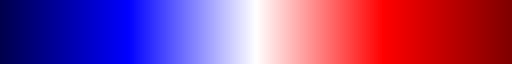

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from datetime import datetime
import xarray as xr
import pandas as pd
import pickle
import netCDF4 as netcdf
from scipy import interpolate, signal
from astropy.convolution import Gaussian2DKernel
from astropy.convolution import convolve as astropy_convolve
from scipy.signal import convolve as scipy_convolve
import seaborn as sns
from CoreBx_funcs import *
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

drv, computername = which_computer()
print('Working on ',computername, 'drv = ',drv)

# path names for output
fig_dir = drv + 'crs/proj/2019_DorianOBX/Dorian_paper_analyses/figs/'
print('fig_dir = ',fig_dir)
out_dir = drv + 'crs/proj/2019_DorianOBX/Dorian_paper_analyses/'
print('out_dir = ',out_dir)

# These commands choose fonts that are editable in svg format
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

# colors
dblue = '#1f77b4'
red3 = ['#fee0d2','#fc9272','#de2d26']
# oranges from ColorBrewer https://colorbrewer2.org/#type=sequential&scheme=PuBu&n=5
cols=['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']
blue5=['#f1eef6','#bdc9e1','#bdc9e1','#2b8cbe','#045a8d']
nblue5 = ['#eff3ff','#bdd7e7','#6baed6','#3182bd','#08519c']
green5=['#edf8e9','#bae4b3','#74c476','#31a354','#006d2c']
purple5 = ['#f2f0f7','#cbc9e2','#9e9ac8','#756bb1','#54278f']

# This is the colormap made in SurferClr2Cmap.ipynb from NorthCore_ElevationShader_v2.clr
fp = open('cmap_ncb.pkl', 'rb')
cmap_ncb = pickle.load(fp)
fp.close()

# This makes NaN gray
tcmap=cmap_ncb
tcmap.set_bad(color='darkgray')

# This is the difference color map
dcmap = cm.seismic.copy()
dcmap.set_bad(color='darkgray')
dcmap

In [2]:
# load in map offsets
with open('offsets.yml') as f:
    offset = yaml.safe_load(f)
offset = np.array(offset)
print(offset)

[ 0.00168195  0.02229009 -0.02397204 -0.01150765 -0.07320715 -0.02726184
 -0.03547332 -0.02953579 -0.02719979  0.00756222]


In [3]:
# Dates for DEMs
dates = ([\
         "2019-08-30",\
         "2019-09-12",\
         "2019-10-11",\
         "2019-11-26"])

nc_path = drv+'crs/proj/2019_DorianOBX/Dorian_paper_analyses/rotated_dems/'

# # these offsets are the mean anomaly relative to the 10-map mean per Analyze_rotated_stable_points_refac
# offset = np.array([0.00168195,  0.02229009, -0.02397204, -0.01150765, -0.07320715, -0.02726184,
#  -0.03547332, -0.02953579, -0.02719979,  0.00756222])

MHHW = 0.4 #elevation of MHHW per VDATUM

# Read in a dict that defines the rotated "island" coordinate system
#  name
#  e0 - UTM Easting of origin [m]
#  n0 - UTM Northing of origin [m]
#  xlen - Length of alongshore axis [m]
#  ylen - Length of cross-shore axis [m]
#  dxdy - grid size (must be isotropic right now) [m]
#  theta - rotation CCW from x-axis [deg]
#  xs_end - number of grid cells to approximate limit of overwash terrace
#  d_end - number of grid cells to 
r = yaml2dict('small_island_box.yml')
print(r)

# initialize maps arrays fo
nmaps = len(dates)
vsum = np.zeros((nmaps))
vsumall = np.zeros((nmaps))
vchange = np.zeros((nmaps-1))
vchangeall = np.zeros((nmaps-1))

statsfn = "process_stats_{}.txt".format(r['name'])
sfile = open(statsfn, "w")

print("",file=sfile)
print('Region: ',r['name'],file=sfile)

{'name': 'ncorebx_small', 'e0': 383520.0, 'n0': 3860830.0, 'xlen': 25000.0, 'ylen': 1200.0, 'dxdy': 1.0, 'theta': 42.0}


### Read in the re-clipped maps to analyze for shoreline and dune crest: `map`

In [4]:
# read in the multi-map reclipped .nc file
fn = r['name']+'_reclip.nc'
dsa = xr.open_dataset(nc_path+fn)
map = np.squeeze(dsa.to_array().to_numpy())
nmaps,ncross,nalong=np.shape(map)
print('nmaps, ncross, nalong: ',nmaps,ncross,nalong)

xdist = dsa['Alongshore'].to_numpy()
ydist = dsa['Cross-shore'].to_numpy()

# Correct for uniform offsets
for i in range(0, nmaps):
    map[i,:,:] = map[i,:,:] - offset[i]

nmaps, ncross, nalong:  4 1200 25000


### Read in new EBK surface Jin-Si created: `SepEBK`

In [5]:
fn = r['name']+'_NCB_Sep_EBK_2022-07-13_rotated.nc'
dsebk = xr.open_dataset(nc_path+fn)
dsebka = np.squeeze(dsebk.to_array())
SepEBK = np.squeeze(np.array(dsebka))
print('Shape of SepEBK:',SepEBK.shape)

Shape of SepEBK: (1200, 25000)


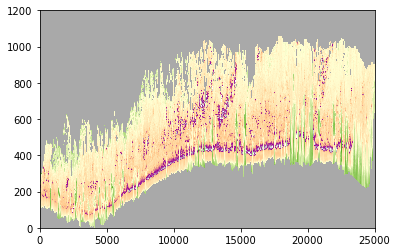

In [6]:
plt.pcolormesh(SepEBK,vmin=-2,vmax=6,cmap=cmap_ncb)

### Read in new October lidar mosaic surface Jin-Si created: `OctLM`

Shape of OctLM: (1200, 25000)


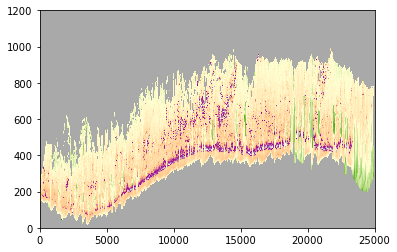

In [7]:
fn = r['name']+'_NCB_Oct_EBK_SfM_lidar_mosiac_cog_rotated.nc'
dsoctlm = xr.open_dataset(nc_path+fn)
dsoctlm = np.squeeze(dsoctlm.to_array())
OctLM = np.squeeze(np.array(dsoctlm))
print('Shape of OctLM:',OctLM.shape)
plt.pcolormesh(OctLM,vmin=-2,vmax=6,cmap=cmap_ncb)

### Read in  November EBK surface Jin-Si created: `NovEBK`

Shape of NovEBK: (1200, 25000)


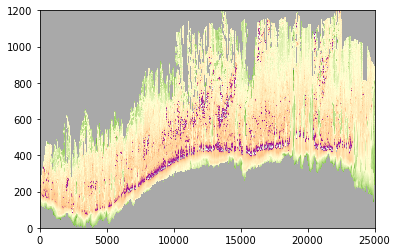

In [8]:
fn = r['name']+'_NCB_Nov_EBK_mosaic_rotated.nc'
dsnovebk = xr.open_dataset(nc_path+fn)
dsnovebk = np.squeeze(dsnovebk.to_array())
NovEBK = np.squeeze(np.array(dsnovebk))
print('Shape of NovEBK:', NovEBK.shape)
plt.pcolormesh(NovEBK,vmin=-2,vmax=6,cmap=cmap_ncb)

### Declare arrays for along-island points
* ydist - alongshore location of each transect (1D array)
* isy - cross-shore shoreline position (2D)
* i4y - cross-shore shoreline position for first point > MHHW (2D)
* idy - cross-shore dune crest postion (2D)
* zshore - elevation at isy (2D)
* zshore4 - elevation at i4y (should be close to MHHW) (2D)
* zdune - elevation at idy (2D)
* bp - number or "bad points" encountered at waters edge for isy (2D; see code)
* bpr - number or "bad points" encountered at waters edge for i4y (2D; see code)
* bpb - ? number or "bad points" encountered at waters edge for isy (2D; see code)

In [9]:
ydist = np.arange(0.,ncross)
isy = np.zeros((nalong, nmaps)) #shoreline location
i4y = np.zeros((nalong, nmaps)) #shoreline using 0.4 m
idy = np.zeros((nalong, nmaps))
zshore = np.zeros((nalong, nmaps))
zshore4 = np.zeros((nalong, nmaps))
zdune = np.zeros((nalong, nmaps))
bp = np.zeros((nalong, nmaps))
bp4 = np.zeros((nalong, nmaps))
bpb = np.zeros((nalong, nmaps))

### Find first valid point (shoreline, kind of): `isy` and `i4y`

In [10]:
%run -i CoreBx_funcs
for j in range(nmaps):
    print('Map',j)
    for i in range(nalong):
        prof = np.squeeze(np.array((map[j,:,i])))
        isy[i,j], zshore[i,j], bp[i,j] = find_first_valid(ydist, prof, i)
        i4y[i,j], zshore4[i,j], bp4[i,j] = find_first_above(ydist, prof, i)

print('Done.')

Map 0
Map 1
Map 2
24976 all nans in find_island_points
24976 all nans in find_first_above
24977 all nans in find_island_points
24977 all nans in find_first_above
24978 all nans in find_island_points
24978 all nans in find_first_above
24979 all nans in find_island_points
24979 all nans in find_first_above
24980 all nans in find_island_points
24980 all nans in find_first_above
24981 all nans in find_island_points
24981 all nans in find_first_above
24982 all nans in find_island_points
24982 all nans in find_first_above
24983 all nans in find_island_points
24983 all nans in find_first_above
24984 all nans in find_island_points
24984 all nans in find_first_above
24985 all nans in find_island_points
24985 all nans in find_first_above
24986 all nans in find_island_points
24986 all nans in find_first_above
24987 all nans in find_island_points
24987 all nans in find_first_above
24988 all nans in find_island_points
24988 all nans in find_first_above
24989 all nans in find_island_points
24989 all

<Figure size 432x288 with 0 Axes>

### Find shorelines for SepEBK surface

In [11]:
isySEBK = np.zeros((nalong)) #shoreline location
i4ySEBK = np.zeros((nalong)) #shoreline using 0.4 m
zshoreSEBK = np.zeros((nalong))
zshore4SEBK = np.zeros((nalong))
bpSEBK = np.zeros((nalong))
bp4SEBK = np.zeros((nalong))
for i in range(nalong):
    prof = np.squeeze(np.array((SepEBK[:,i])))
    isySEBK[i], zshoreSEBK[i], bpSEBK[i] = find_first_valid(ydist, prof, i)
    i4ySEBK[i], zshore4SEBK[i], bp4SEBK[i] = find_first_above(ydist, prof, i)

print('Done.')

Done.


### Find shorelines for OctLM surface

In [12]:
isyOctLM = np.zeros((nalong)) #shoreline location
i4yOctLM = np.zeros((nalong)) #shoreline using 0.4 m
zshoreOctLM = np.zeros((nalong))
zshore4OctLM = np.zeros((nalong))
bpOctLM = np.zeros((nalong))
bp4OctLM = np.zeros((nalong))
for i in range(nalong):
    prof = np.squeeze(np.array((OctLM[:,i])))
    isyOctLM[i], zshoreOctLM[i], bpOctLM[i] = find_first_valid(ydist, prof, i)
    i4yOctLM[i], zshore4OctLM[i], bp4OctLM[i] = find_first_above(ydist, prof, i)

print('Done.')

24977 all nans in find_island_points
24977 all nans in find_first_above
24978 all nans in find_island_points
24978 all nans in find_first_above
24979 all nans in find_island_points
24979 all nans in find_first_above
24980 all nans in find_island_points
24980 all nans in find_first_above
24981 all nans in find_island_points
24981 all nans in find_first_above
24982 all nans in find_island_points
24982 all nans in find_first_above
24983 all nans in find_island_points
24983 all nans in find_first_above
24984 all nans in find_island_points
24984 all nans in find_first_above
24985 all nans in find_island_points
24985 all nans in find_first_above
24986 all nans in find_island_points
24986 all nans in find_first_above
24987 all nans in find_island_points
24987 all nans in find_first_above
24988 all nans in find_island_points
24988 all nans in find_first_above
24989 all nans in find_island_points
24989 all nans in find_first_above
24990 all nans in find_island_points
24990 all nans in find_firs

### Find shorelines for NovEBK surface

In [13]:
isyNovEBK = np.zeros((nalong)) #shoreline location
i4yNovEBK = np.zeros((nalong)) #shoreline using 0.4 m
zshoreNovEBK = np.zeros((nalong))
zshore4NovEBK = np.zeros((nalong))
bpNovEBK = np.zeros((nalong))
bp4NovEBK = np.zeros((nalong))
for i in range(nalong):
    prof = np.squeeze(np.array((NovEBK[:,i])))
    isyNovEBK[i], zshoreNovEBK[i], bpNovEBK[i] = find_first_valid(ydist, prof, i)
    i4yNovEBK[i], zshore4NovEBK[i], bp4NovEBK[i] = find_first_above(ydist, prof, i)

print('Done.')

Done.


### Statistics for shoreline elevations

In [14]:
print('Shape of isy:',np.shape(isy))
print('Mean of zshore: ',np.nanmean(zshore,0))
print('Mean of zshore4: ',np.nanmean(zshore4,0))
print('Min. of zshore: ',np.nanmin(zshore,0))

Shape of isy: (25000, 4)
Mean of zshore:  [ 0.10728721  0.11267002  0.6448062  -0.14234834]
Mean of zshore4:  [0.48814312 0.48166686 0.70129674 0.46515808]
Min. of zshore:  [-0.84931612 -1.16391575 -2.96463656 -3.2415278 ]


### Export shoreline locations to csv

In [15]:
csv_dir = drv+'crs/proj/2019_DorianOBX/Best_files/csv/'
Aug_shorex, Aug_shorey = island2UTM(xdist, isy[:,0], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Aug_shorex, Aug_shorey)).T).round(decimals=2)).to_csv(csv_dir+'Aug_shoreline.csv',header=None, index=None)

Sep_shorex, Sep_shorey = island2UTM(xdist, isy[:,1], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Sep_shorex, Sep_shorey)).T).round(decimals=2)).to_csv(csv_dir+'Sep_shoreline.csv',header=None, index=None)

Oct_shorex, Oct_shorey = island2UTM(xdist, isy[:,2], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Oct_shorex, Oct_shorey)).T).round(decimals=2)).to_csv(csv_dir+'Oct_shoreline.csv',header=None, index=None)

Nov_shorex, Nov_shorey = island2UTM(xdist, isy[:,3], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Nov_shorex, Nov_shorey)).T).round(decimals=2)).to_csv(csv_dir+'Nov_shoreline.csv',header=None, index=None)

### Export MHHW shorelines to CSV

In [16]:
csv_dir = drv+'crs/proj/2019_DorianOBX/Best_files/csv/'
Aug_shorex, Aug_shorey = island2UTM(xdist, i4y[:,0], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Aug_shorex, Aug_shorey)).T).round(decimals=2)).to_csv(csv_dir+'Aug_4shoreline.csv',header=None, index=None)

Sep_shorex, Sep_shorey = island2UTM(xdist, i4y[:,1], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Sep_shorex, Sep_shorey)).T).round(decimals=2)).to_csv(csv_dir+'Sep_4shoreline.csv',header=None, index=None)

Oct_shorex, Oct_shorey = island2UTM(xdist, i4y[:,2], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Oct_shorex, Oct_shorey)).T).round(decimals=2)).to_csv(csv_dir+'Oct_4shoreline.csv',header=None, index=None)

Nov_shorex, Nov_shorey = island2UTM(xdist, i4y[:,3], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Nov_shorex, Nov_shorey)).T).round(decimals=2)).to_csv(csv_dir+'Nov_4shoreline.csv',header=None, index=None)

### Export SepEBK, OctLM, and NovEBK shorelines to CSV

In [17]:
Sep_shorexEBK, Sep_shoreyEBK = island2UTM(xdist, isySEBK[:], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Sep_shorexEBK, Sep_shoreyEBK)).T).round(decimals=2)).to_csv(csv_dir+'SepEBK_shoreline.csv',header=None, index=None)

Sep_shorexEBK4, Sep_shoreyEBK4 = island2UTM(xdist, i4ySEBK[:], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Sep_shorexEBK4, Sep_shoreyEBK4)).T).round(decimals=2)).to_csv(csv_dir+'SepEBK_4shoreline.csv',header=None, index=None)

Oct_shorexLM, Oct_shoreyLM = island2UTM(xdist, isyOctLM[:], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Oct_shorexLM, Oct_shoreyLM)).T).round(decimals=2)).to_csv(csv_dir+'OctLM_shoreline.csv',header=None, index=None)

Oct_shorexLM4, Oct_shoreyLM4 = island2UTM(xdist, i4yOctLM[:], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Oct_shorexLM4, Oct_shoreyLM4)).T).round(decimals=2)).to_csv(csv_dir+'OctLM_4shoreline.csv',header=None, index=None)

Nov_shorexEBK, Nov_shoreyEBK = island2UTM(xdist, isyNovEBK[:], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Nov_shorexEBK, Nov_shoreyEBK)).T).round(decimals=2)).to_csv(csv_dir+'NovEBK_shoreline.csv',header=None, index=None)

Nov_shorexEBK4, Nov_shoreyEBK4 = island2UTM(xdist, i4yNovEBK[:], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Nov_shorexEBK4, Nov_shoreyEBK4)).T).round(decimals=2)).to_csv(csv_dir+'NovEBK_4shoreline.csv',header=None, index=None)


### Smooth the maps with a 5-point Gaussian kernal that will fill in NaNs: `maps`
The boundary='fill' and fill_value=np.nan arguments prevent the default behavior of putting zeros where kernel touches boundaries.  

New 3d array: *dsaas*

In [18]:
%%time
ismooth = True
maps = np.copy(map)
if ismooth:
    kernel = Gaussian2DKernel(x_stddev=.5)
    print('Size of kernel: ', kernel.shape)
    
    for i in range(0, nmaps):
        maps[i,:,:] = astropy_convolve(map[i,:,:], kernel, boundary='fill', fill_value=np.nan)

Size of kernel:  (5, 5)
CPU times: total: 15.9 s
Wall time: 15.9 s


### Read in the digitized profile of dune crest profile; convert to island coords

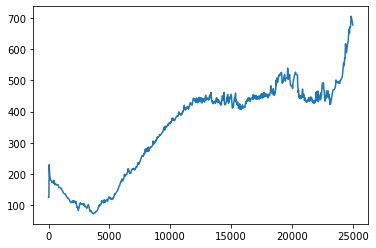

In [19]:
df=pd.read_csv(drv+"\\crs\\proj\\2019_DorianOBX\\WayneWright_flights\\CoreBx\\dune_line_2.csv",header = None)

xUTM=df.loc[:,0].values
yUTM=df.loc[:,1].values

xdune,ydune=UTM2Island(xUTM, yUTM, eoff=r['e0'], noff=r['n0'], rot=r['theta'])
# y = np.arange(0,nalong+1.)
f = interpolate.interp1d(xdune,ydune,bounds_error=False,fill_value=np.nan)
ydunei = f(xdist)

plt.plot(ydunei)

### Find dune crest and back of island platform using smoothed arrays: `idy`, `zdune`

Map 0
412 452 432 434
Map 1
412 452 432 434
Map 2
412 452 432 434
24978 all nans in find_dune
24979 all nans in find_dune
24980 all nans in find_dune
24981 all nans in find_dune
24982 all nans in find_dune
24983 all nans in find_dune
24984 all nans in find_dune
24985 all nans in find_dune
24986 all nans in find_dune
24987 all nans in find_dune
24988 all nans in find_dune
24989 all nans in find_dune
24990 all nans in find_dune
24991 all nans in find_dune
24992 all nans in find_dune
24993 all nans in find_dune
24994 all nans in find_dune
24995 all nans in find_dune
24996 all nans in find_dune
24997 all nans in find_dune
24998 all nans in find_dune
24999 all nans in find_dune
Map 3
412 452 432 434
Done.


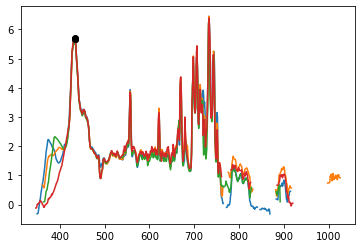

In [20]:
%run -i CoreBx_funcs
for j in range(nmaps):
    print('Map',j)
    for i in range(nalong):
        prof = np.squeeze(np.array((maps[j,:,i])))
        idy[i,j], zdune[i,j] = find_dune(ydist, prof, isy[i,0], ydunei[i], i)
print('Done.')

In [21]:
print('Mean dune crest elevation: ',np.nanmean(zdune,0))
print('Std. dune crest elevation: ',np.nanstd(zdune,0))

Mean dune crest elevation:  [4.03052567 3.77570439 3.76167863 3.76076206]
Std. dune crest elevation:  [1.33880068 1.65842876 3.56833142 1.63310464]


#### Rotate these to UTM and export to .csv

In [22]:
# export these locations to csv
csv_dir = drv+'crs/proj/2019_DorianOBX/Best_files/csv/'
    
Aug_dunex, Aug_duney = island2UTM(xdist, idy[:,0], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Aug_dunex, Aug_duney, zdune[:,0])).T).round(decimals=2)).to_csv(csv_dir+'Aug_dune.csv',header=None, index=None)
Sep_dunex, Sep_duney = island2UTM(xdist, idy[:,1], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Sep_dunex, Sep_duney, zdune[:,1])).T).round(decimals=2)).to_csv(csv_dir+'Sep_dune.csv',header=None, index=None)
Oct_dunex, Oct_duney = island2UTM(xdist, idy[:,2], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Oct_dunex, Oct_duney, zdune[:,2])).T).round(decimals=2)).to_csv(csv_dir+'Oct_dune.csv',header=None, index=None)
Nov_dunex, Nov_duney = island2UTM(xdist, idy[:,3], r['e0'], r['n0'], r['theta'])
pd.DataFrame((np.vstack((Nov_dunex, Nov_duney, zdune[:,3])).T).round(decimals=2)).to_csv(csv_dir+'Nov_dune.csv',header=None, index=None)

### Read in the digitized profile for the back side at the ~1.25-m contour interval
(this looks more like the 0.75-m contour when plotted against that contour derived from lidar ground points.

Stat summary of island width (iswide)
  n, nnan, nvalid:  25000 0 25000
  mean, std, min, max   : 260.892 77.296 0.000 492.284
  d5, d25, d50, d75, d95: 130.494 213.562 262.624 313.341 377.522


Text(0, 0.5, 'Cross-shore distance (m)')

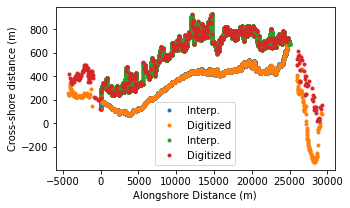

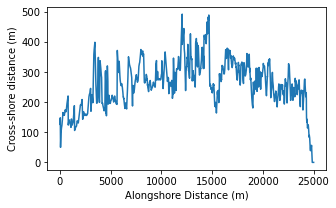

In [23]:
dfb=pd.read_csv(drv+"crs/proj/2019_DorianOBX/WayneWright_flights/CoreBx/back_125.csv",header = None)
xUTMb=dfb.loc[:,0].values
yUTMb=dfb.loc[:,1].values

# rotate to alongshore/cross-shore coordinates
xback,yback=UTM2Island(xUTMb, yUTMb, eoff=r['e0'], noff=r['n0'], rot=r['theta'])

# interpolate
fb = interpolate.interp1d(xback,yback,bounds_error=False,fill_value=np.nan)
iyback = fb(xdist)

# ensure back >= dune
iyback[iyback<ydunei]=ydunei[iyback<ydunei]
iswide = iyback-ydunei

print("Stat summary of island width (iswide)")
stat_summary(iswide,iprint=True)

fig = plt.figure(figsize=(5,3))
plt.plot(xdist,ydunei,'.',label="Interp.")
plt.plot(xdune,ydune,'.',label='Digitized')
plt.plot(xdist,iyback,'.',label="Interp.")
plt.plot(xback,yback,'.',label='Digitized')
plt.legend()
plt.xlabel('Alongshore Distance (m)')
plt.ylabel('Cross-shore distance (m)')

fig = plt.figure(figsize=(5,3))
plt.plot(xdist,iswide,'-')
plt.xlabel('Alongshore Distance (m)')
plt.ylabel('Cross-shore distance (m)')

### Copy smoothed, trimmed maps to arrays: `Augs`, `Seps`, `Octs`, `Novs`

In [24]:
Augs = np.squeeze(np.array(maps[0,:,:]))
Seps = np.squeeze(np.array(maps[1,:,:]))
Octs = np.squeeze(np.array(maps[2,:,:]))
Novs = np.squeeze(np.array(maps[3,:,:]))

### Replace NaNs in `maps` on beach and platform with 0, -1, -1.5, and -2: `map0`, `map1`, `map15`, `map2`

In [25]:
%run -i CoreBx_funcs.py

map0 = np.copy(maps)
x = 0.
for j in range(nmaps):
    print('\nx = {}, map[{:d}]'.format(x,j))
    map0[j,:,:] = replace_nans_with_x(np.squeeze(map0[j,:,:]), x, isy[:,j], iyback)
    
map1 = np.copy(maps)
x = -1.
for j in range(nmaps):
    print('\nx = {}, map[{:d}]'.format(x,j))
    map1[j,:,:] = replace_nans_with_x(np.squeeze(map1[j,:,:]), x, isy[:,j], iyback)
    
map15 = np.copy(maps)
x = -1.5
for j in range(nmaps):
    print('\nx = {}, map[{:d}]'.format(x,j))
    map15[j,:,:] = replace_nans_with_x(np.squeeze(map15[j,:,:]), x, isy[:,j], iyback)
    
map2 = np.copy(maps)
x = -2.
for j in range(nmaps):
    print('\nx = {}, map[{:d}]'.format(x,j))
    map2[j,:,:] = replace_nans_with_x(np.squeeze(map2[j,:,:]), x, isy[:,j], iyback)


x = 0.0, map[0]
Sum points: 8901020.0
Sum replaced: 8129.0
Fraction replaced: 0.0009132661200626445
Median number replaced 0.0
Max. number replaced 94.0
Median fraction replaced 0.0

x = 0.0, map[1]
Sum points: 8405684.0
Sum replaced: 100871.0
Fraction replaced: 0.012000332156193358
Median number replaced 0.0
Max. number replaced 238.0
Median fraction replaced 0.0

x = 0.0, map[2]
Sum points: 8156740.0
Sum replaced: 295803.0
Fraction replaced: 0.03626485581249372
Median number replaced 0.0
Max. number replaced 682.0
Median fraction replaced 0.0

x = 0.0, map[3]
Sum points: 9110746.0
Sum replaced: 85854.0
Fraction replaced: 0.009423377624620421
Median number replaced 0.0
Max. number replaced 213.0
Median fraction replaced 0.0

x = -1.0, map[0]
Sum points: 8901020.0
Sum replaced: 8129.0
Fraction replaced: 0.0009132661200626445
Median number replaced 0.0
Max. number replaced 94.0
Median fraction replaced 0.0

x = -1.0, map[1]
Sum points: 8405684.0
Sum replaced: 100871.0
Fraction replaced

<Figure size 432x288 with 0 Axes>

### Fill holes in `maps` with *astropy* interpolation: `mapAPFN`

In [26]:
%%time
from astropy.convolution import interpolate_replace_nans
mapAPFN = np.nan*np.ones_like(maps)
kernel = Gaussian2DKernel(x_stddev=4)
print('Size of kernel: ', kernel.shape)
for j in range(nmaps):
    mapAPFN[j,:,:] = interpolate_replace_nans(np.squeeze(maps[j,:,:]), kernel, boundary='fill', fill_value=np.nan)

Size of kernel:  (33, 33)
CPU times: total: 9min 38s
Wall time: 9min 38s


### Replace NaNs in `OctLM` with `SepEBK`: `OctLMEBK`

522 62
[827 828 829 830 831 832 833 834 835 836 837 838 839 840 841 842 843 844
 845 846 847 848 849 850 851 852 853 854 855 856 857 858 859 860 861 862
 863 864 865 866 867 868 869 870 871 872 873 874 875 876 877 878 879 880
 881 882 883 884 885 886 887 888]
Sum points: 8546471.0
Sum replaced: 67309.0
Fraction replaced: 0.007875648323149988
Median number replaced 0.0
Max. number replaced 682.0
Median fraction replaced 0.0


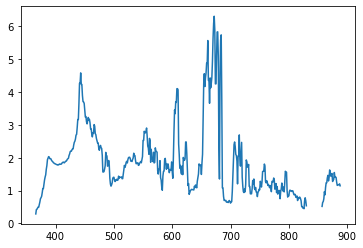

In [27]:
OctLMEBK = np.copy(OctLM)
# arrays for statistics
sum_prof = np.zeros(nalong)
sum_repl = np.zeros(nalong)

for i in range(nalong):
    # cross-island indices of beach, island back
    ibeach = int(isyOctLM[i])     # beach varies with survey
    ibck = int(iyback[i])    # yback is constant

    # Find nans, replace with values from SepEBK
    tmp_prof = np.squeeze(OctLMEBK[:,i])
    ireplace = np.argwhere(np.isnan(tmp_prof))
    ireplace = ireplace[ np.where( ireplace >= ibeach) ]
    ireplace = ireplace[ np.where( ireplace <= ibck)]
    sum_prof[i] = (ibck-ibeach)
    sum_repl[i]= len(ireplace)
    tmp_prof[ireplace] = SepEBK[ireplace,i]
    # look at random profile for sanity check
    if i == 12000:
        print(ibck-ibeach, len(ireplace))
        print(ireplace)
        plt.plot(tmp_prof)
    OctLMEBK[:,i]=tmp_prof
        
print('Sum points:', np.nansum(sum_prof))
print('Sum replaced:', np.nansum(sum_repl))
print('Fraction replaced:', np.nansum(sum_repl)/np.nansum(sum_prof))
print('Median number replaced', np.nanmedian(sum_repl))
print('Max. number replaced', np.nanmax(sum_repl))
print('Median fraction replaced', np.nanmedian( sum_repl/sum_prof)) 

### Best map is combo of `Augs`, `SepEBK`, `OctLMEBK`, and `NovEBK`: `mapEBK`

In [28]:
mapEBK = np.copy(maps)
mapEBK[0,:,:] = Augs
mapEBK[1,:,:] = SepEBK
mapEBK[2,:,:] = OctLMEBK
mapEBK[3,:,:] = NovEBK

### Now we have `map`, `maps`, `map0`, `mapAPFN`, and `mapEBK`

### Calculate volumes for generic `mapx`

In [29]:
# skip NaN map...same as map0
maplist = ['map0','map1','map2','mapAPFN','mapEBK']
mapname = 'Fill 0','Fill -1','Fill -2', 'Fill Gauss','Fill EBK'
n = len(maplist)
print('Total number or maps:',n)
vp_tot = np.zeros((n, nmaps))
vb_tot = np.zeros((n, nmaps))
va_tot = np.zeros((n, nmaps))
ap_tot = np.zeros((n, nmaps))
ab_tot = np.zeros((n, nmaps))
aa_tot = np.zeros((n, nmaps))   

Total number or maps: 5


In [30]:
# make special shoreline for EBK surface combo
i4yEBK = np.zeros_like(i4y)
i4yEBK[:,0] = i4y[:,0]
i4yEBK[:,1] = i4ySEBK
i4yEBK[:,2] = i4yOctLM
i4yEBK[:,3] = i4yNovEBK
print(i4yEBK.shape)

(25000, 4)


In [31]:
for k, mapy in enumerate(maplist):
    expr = 'mapx = ' + mapy
    print(expr)
    exec(expr)
    # Use MHW for shoreline
    ishoreliney = i4y
    # Unless EBK/Lidar merge, then use that shoreline
    if mapy == 'mapEBK':
        print('Using EBK shoreline')
        ishoreliney = i4yEBK
        
    # arrays for saving results
    all_vol   = np.zeros((nalong, nmaps))
    beach_vol = np.zeros((nalong, nmaps))
    plat_vol  = np.zeros((nalong, nmaps))

    beach_width  = np.zeros((nalong, nmaps))
    platform_width = np.zeros((nalong, nmaps))
    island_width = np.zeros((nalong, nmaps))

    for j in range(nmaps):
        for i in range(nalong):
            # cross-island indices of shore, dune crest, island back
            ishore = int(ishoreliney[i,j])    # shoreline adjusts with each map
            idune = int(idy[i,0])     # dune crest stays at August value
            ibck = int(iyback[i])   # yback is constant

            # calculate widths
            beach_width[i,j] = idune - ishore
            platform_width[i,j] = ibck - idune
            island_width[i,j] = ibck - ishore

            # calculate volume
            tmp_prof = mapx[j,:,i]
            all_vol[i,j]   = np.nansum(tmp_prof[ishore:ibck])
            beach_vol[i,j] = np.nansum(tmp_prof[ishore:idune])
            plat_vol[i,j]  = np.nansum(tmp_prof[idune:ibck])      

    vp_tot[k,:] = np.nansum(plat_vol,0)
    vb_tot[k,:] = np.nansum(beach_vol,0)
    va_tot[k,:] = np.nansum(all_vol,0)
    ap_tot[k,:] = np.nansum(platform_width,0)
    ab_tot[k,:] = np.nansum(beach_width,0)
    aa_tot[k,:] = np.nansum(island_width,0)

mapx = map0
mapx = map1
mapx = map2
mapx = mapAPFN
mapx = mapEBK
Using EBK shoreline


In [32]:
# sum volumes over all transects
for k in range(n):
    print('\nVolumes for ',mapname[k])
    print('Date        P vol    B vol  Tot vol  P area  B area   P Frac  T Frac   P Elev  B Elev')
    for i, d in enumerate(dates):
        print('{}  {:.2f}     {:.2f}   {:.2f}    {:.2f}   {:.2f}     {:.3f}   {:.3f}    {:.2f}    {:.2f}'.
              format(dates[i],vp_tot[k,i]/1e6,vb_tot[k,i]/1e6,va_tot[k,i]/1e6,ap_tot[k,i]/1e6,
                     ab_tot[k,i]/1e6,vp_tot[k,i]/vp_tot[k,0],va_tot[k,i]/va_tot[k,0],
                     vp_tot[k,i]/ap_tot[k,i], vb_tot[k,i]/ab_tot[k,i]))


Volumes for  Fill 0
Date        P vol    B vol  Tot vol  P area  B area   P Frac  T Frac   P Elev  B Elev
2019-08-30  12.52     4.07   16.59    6.51   2.28     1.000   1.000    1.92    1.78
2019-09-12  10.92     2.51   13.43    6.51   1.39     0.872   0.810    1.68    1.81
2019-10-11  10.78     2.72   13.50    6.51   1.60     0.861   0.814    1.66    1.70
2019-11-26  11.22     2.73   13.95    6.51   1.85     0.896   0.841    1.72    1.47

Volumes for  Fill -1
Date        P vol    B vol  Tot vol  P area  B area   P Frac  T Frac   P Elev  B Elev
2019-08-30  12.51     4.07   16.58    6.51   2.28     1.000   1.000    1.92    1.78
2019-09-12  10.85     2.50   13.38    6.51   1.39     0.867   0.807    1.67    1.81
2019-10-11  10.54     2.68   13.23    6.51   1.60     0.843   0.798    1.62    1.68
2019-11-26  11.14     2.72   13.87    6.51   1.85     0.891   0.836    1.71    1.47

Volumes for  Fill -2
Date        P vol    B vol  Tot vol  P area  B area   P Frac  T Frac   P Elev  B Elev
2019-

### Calculate uncertainties
These only depend on the areas...all other coefficients are from the uncertainty analysis.
Use the biggest beach areas, which are the from the interpolaton schemes.

In [33]:
k = 4
# for platform volumes
sigma_rs = np.ones(4)*np.nan
sigma_sc = sigma_rs.copy()
# for beach volumes
sigma_rsb = sigma_rs.copy()
sigma_scb = sigma_rs.copy()
sigma_rmsd = np.sqrt(2.*0.2**2)
print('sigma_rmsd:',sigma_rmsd)

L2 = 1. # 1-m grid
for imap in range((nmaps)):

    # Uncorrelated random error
    an = ap_tot[k,imap] # approximate area
    bn = ab_tot[k,imap]
    #print('areas:', an, bn)
    sigma_rs[imap] = sigma_rmsd/np.sqrt(an)
    sigma_rsb[imap] = sigma_rmsd/np.sqrt(bn)

    # Spatially correlated data (max values)
    sill = np.sqrt(0.03)
    sigma_sill = np.sqrt(sill)
    rng = 360.
    sigma_sc[imap] = (sigma_sill/np.sqrt(an)) * np.sqrt((np.pi*rng**2)/(5.*L2))
    sigma_scb[imap] = (sigma_sill/np.sqrt(bn)) * np.sqrt((np.pi*rng**2)/(5.*L2))

    Asc = np.pi*rng**2/(5.*an*L2)
    Ascb = np.pi*rng**2/(5.*bn*L2)

    #print('Asc: ',Asc, Ascb)
    
# Systematic error
sigma_sys = 0.07

# total error
sigma_tot = np.sqrt( sigma_rs**2. + sigma_sc**2. + sigma_sys**2.)
sigma_totb = np.sqrt( sigma_rsb**2. + sigma_scb**2. + sigma_sys**2.)

for i in range(nmaps-1):
    # calculate stats for platform and beach widths
    ss=stat_summary(platform_width[i,:],iprint=False)
    ssb=stat_summary(beach_width[i,:],iprint=False)
#     print('Platform and beach median widths: {:.3f}, {:.3f}'.format(ss['d50'],ssb['d50']))
#     print('sigma_rs:           {:.6f}, {:.6f}'.format(sigma_rs[i], sigma_rsb[i]))
#     print('sigma_sc:           {:.6f}, {:.6f}'.format(sigma_sc[i], sigma_scb[i]))
#     print('sigma_tot:          {:.6f}, {:.6f}'.format(sigma_tot[i], sigma_totb[i]))

# print('ap_tot: ',ap_tot)
# print('vp_tot: ',vp_tot)
# print('avg. elevation: ',vp_tot/ap_tot)
vdiff = np.diff(vp_tot,1,0)
# print('diff(vp_tot):',vdiff)
# print('diff as fraction of initial volume: ',vdiff/vp_tot[0])
# print('diff per meter',vdiff/36650.)
err = ap_tot[k,:]*sigma_tot
errb = ab_tot[k,:]*sigma_totb

# print('err volumes',err,errb)
# print('err as frac of volume initial volume: ',err/vp_tot[0])
# print('err as frac of volume change:',np.mean(err)/vdiff)
# print('avg. elevation change: ',vdiff/np.mean(ap_tot))

sigma_rmsd: 0.28284271247461906


In [34]:
stat_summary(beach_width[:,0],iprint=True)

  n, nnan, nvalid:  25000 0 25000
  mean, std, min, max   : 91.245 66.295 -14.000 502.000
  d5, d25, d50, d75, d95: 50.000 61.000 72.000 88.000 202.000


{'n': 25000,
 'nnan': 0,
 'nvalid': 25000,
 'mean': 91.24456,
 'std': 66.2947227945513,
 'min': -14.0,
 'max': 502.0,
 'd5': 50.0,
 'd25': 61.0,
 'd50': 72.0,
 'd75': 88.0,
 'd95': 202.0}

(4,)


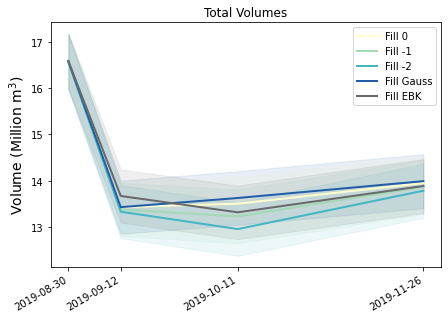

In [35]:
fillcols = ['#ffffcc','#a1dab4','#41b6c4','#225ea8','dimgray',cols[4]]
errt = np.sqrt(err**2+errb**2)
print(errt.shape)

vol0 = va_tot[0,0]*np.ones_like(va_tot[0,:])
volp0 = vp_tot[0,0]*np.ones_like(vp_tot[0,:])

dtl = []
for date in dates:
    dtl.append(datetime.strptime(date, "%Y-%m-%d"))
dt = np.array(dtl)

fig, ax = plt.subplots(1,1,figsize=(7,5))
fig.autofmt_xdate()
#for k in range(6):
for k in range(5):
    fillvol = np.squeeze(va_tot[k,:])/1e6
    fillerr = np.squeeze(errt)/1e6
    plt.fill_between(dt[0:4], fillvol+fillerr, fillvol-fillerr, color=fillcols[k], alpha=0.1 )
    plt.plot(dt,va_tot[k,:]/1e6, linewidth=2, color=fillcols[k],label=mapname[k])
plt.xticks(dt)
plt.ylabel('Volume (Million m$^3$)', fontsize=14,)
plt.legend()
plt.title('Total Volumes')
plt.savefig( fig_dir+'total_volumes_error_bars.svg' ) 
plt.savefig( fig_dir+'total_volumes_error_bars.png' ) 

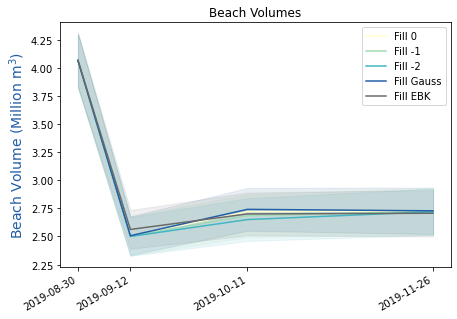

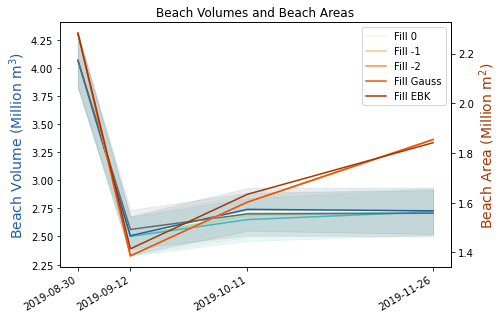

In [36]:
fig, ax1 = plt.subplots(1,1,figsize=(7,5))
fig.autofmt_xdate()

for k in range(5):
    fillvol = np.squeeze(vb_tot[k,:])/1e6
    fillerr = np.squeeze(errb)/1e6
    ax1.fill_between(dt[0:4], fillvol+fillerr, fillvol-fillerr, color=fillcols[k], alpha=0.1 )
    ax1.plot(dt,vb_tot[k,:]/1e6, color=fillcols[k], label=mapname[k])
plt.xticks(dt)
ax1.set_ylabel('Beach Volume (Million m$^3$)', fontsize=14, color = fillcols[3])
plt.legend()
plt.title('Beach Volumes')
plt.savefig( fig_dir+'beach_volumes.svg' ) 


fig, ax1 = plt.subplots(1,1,figsize=(7,5))
fig.autofmt_xdate()
ax2 = ax1.twinx()

for k in range(5):
    fillvol = np.squeeze(vb_tot[k,:])/1e6
    fillerr = np.squeeze(errb)/1e6
    ax1.fill_between(dt[0:4], fillvol+fillerr, fillvol-fillerr, color=fillcols[k], alpha=0.1 )
    ax1.plot(dt,vb_tot[k,:]/1e6, color=fillcols[k], label=mapname[k])

for k in range(5):
    plt.plot(dt,ab_tot[k,:]/1e6, color=cols[k],label=mapname[k])

plt.xticks(dt)
ax1.set_ylabel('Beach Volume (Million m$^3$)', fontsize=14, color = fillcols[3])
ax1.spines['left'].set_color(fillcols[3])
ax2.set_ylabel('Beach Area (Million m$^2$)', fontsize=14, color = cols[4])
#ax2.spines['right'].set_color(cols[4])

plt.legend()
plt.title('Beach Volumes and Beach Areas')
plt.savefig( fig_dir+'beach_volumes_and_areas.svg' ) 


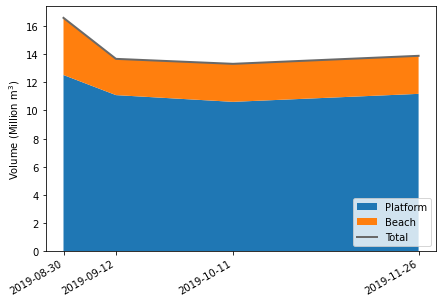

In [37]:
dtl = []
for date in dates:
    dtl.append(datetime.strptime(date, "%Y-%m-%d"))
dt = np.array(dtl)

fig, ax = plt.subplots(1,1,figsize=(7,5))
fig.autofmt_xdate()
ax.stackplot(dt, vp_tot[k,:]/1e6, vb_tot[k,:]/1e6, labels=['Platform','Beach'])
ax.plot(dt,va_tot[k,:]/1e6,'-',linewidth=2,c='dimgray',label='Total')
ax.legend(loc='lower right')
plt.xticks(dt)
plt.ylabel('Volume (Million m$^3$)')
plt.show()

# This is a test map + profile figure that can be relocated
from IPython.display import display, Latex
figdir = drv+'/crs/proj/2019_DorianOBX/Dorian_paper_analyses/figs/'

mapa = np.squeeze(map0[2,:,:])
mapb = np.squeeze(mapAPFN[2,:,:])
mapd = mapb-mapa
imap = 1

yss = 18000     # alongshore start
dyy = 1000      # alongshore extent
yse = yss + dyy # alongshore end

xss = 200       # cross-shore start
dxx = 1000      # cross-shore extent
xse = xss+dxx   # cross-shore end
print('xse:',xse)

#label0 = dates[imap]
#label1 = dates[imap+1]
label0 = 'Novs'
label1 = 'NovAPFN'
label2 =  label1+'_minus_'+label0
figname = label2

dvol = np.nansum(mapd[xss:xse,yss:yse])
dvm = dvol/(dyy)
ts = '$\Delta$ Vol. = {:.0f} m$^3$; {:.1f} m$^3$/m'.format(dvol, dvm)
display(Latex(ts))
yticks = np.arange(xss,xse,200)
print('yticks:',yticks)
xticks = np.arange(yss,yse+1,200)
print('xticks:',xticks)

print(map0[xss:xse,yss:yse].shape)
fix, axes = plt.subplots(1,3,figsize=(15,4),sharey='row')
axes[0].pcolormesh(map0[xss:xse,yss:yse],vmin=-2,vmax=6,cmap=cmap_ncb)
axes[1].pcolormesh(map1[xss:xse,yss:yse],vmin=-2,vmax=6,cmap=cmap_ncb)
axes[2].pcolormesh(mapd[xss:xse,yss:yse],vmin=-2,vmax=2,cmap=dcmap)
for i in range(0,3):
    yvals = np.ones(2)*(i+1)*int(dyy/4)
    xvals = np.array((0.,dxx))

    dcrest_along = yvals[0]
    dcrest_cross = idy[yss+(i+1)*int(dyy/4), imap]-xss
    print(dcrest_along, (i+1)*int(dyy/4), dcrest_cross)
    axes[0].plot(yvals,xvals,'--',c='gray')
    axes[0].plot(dcrest_along,dcrest_cross,'ok')
    axes[1].plot(yvals,xvals,'--',c='gray')
    axes[1].plot(dcrest_along,dcrest_cross,'ok')
    axes[2].plot(yvals,xvals,'--',c='gray')
    axes[2].plot(dcrest_along,dcrest_cross,'ok')
    axes[i].set_xticklabels(xticks)
   
axes[0].text(.05,.92,'a) '+label0,transform=axes[0].transAxes)
axes[1].text(.05,.92,'b) '+label1,transform=axes[1].transAxes)
axes[2].text(.05,.92,'c) '+label2,transform=axes[2].transAxes)
axes[2].text(.05,.85, ts,transform=axes[2].transAxes)
axes[0].set_yticks(yticks)
axes[0].set_ylabel('Cross-shore Distance (m)')
axes[1].set_xlabel('Alongshore Distance (m)')

plt.savefig(figdir+'map_'+figname+'.jpg',dpi=200)

fig, axes = plt.subplots(3,1,figsize=(15,4),sharex=True)
for i, ax in enumerate(axes):
    idx = yss+(i+1)*int(dyy/4) # index into transect
    print('idx, idy',idx, idy[idx,:])
    ax.plot(idy[idx,imap],zdune[idx,imap],'o',c=blue5[3])
    ax.plot(idy[idx,imap],zdune[idx,imap],'o',c=purple5[4])

    ax.plot(ydist[xss:xse],np.squeeze(map0[xss:xse,idx]),c=blue5[3],label=label0)
    ax.plot(ydist[xss:xse],np.squeeze(map1[xss:xse,idx]),c=purple5[4],label=label1)

axes[0].legend(loc='upper right')
axes[0].set_xlim(xmin=xss, xmax=xse)
ttext = 'Cross-shore Profiles, map{}, Alongshore {:0d}'.format(imap,yss)
axes[0].set_title(ttext)
axes[-1].set_xlabel('Cross-shore Distance (m)')
axes[1].set_ylabel('Elevation (m NAVD88')
plt.savefig(figdir+'prof_'+figname+'.png',dpi=200)

### Put results for map *k* in a Pandas dataframe

In [38]:
k = 4
pd.set_option("display.precision", 2)
df = pd.DataFrame({'Date':dates,
                   'Platform Vol. (Mm3)':vp_tot[k,:]/1e6,
                   'Beach Vol. (Mm3)': vb_tot[k,:]/1e6,
                   'Total Vol. (Mm3)': (vb_tot[k,:]+vp_tot[k,:])/1e6,
                   'Platform Area (Mm2)':ap_tot[k,:]/1e6,
                   'Beach Area (Mm2)':ab_tot[k,:]/1e6,
                   'Total Area (Mm2)':(ap_tot[k,:]+ab_tot[k,:])/1e6,
                   'Frac. Plat. Vol.':vp_tot[k,:]/vp_tot[k,0],
                   'Frac. Beach. Vol.':vb_tot[k,:]/vb_tot[k,0],
                   'Frac. Tot. Vol.':(vb_tot[k,:]+vp_tot[k,:])/(vb_tot[k,0]+vp_tot[k,0]),
                   'Frac. Err. Plat. Vol.':err/vp_tot[k,:],
                   'Frac. Err. Beach Vol.':errb/vb_tot[k,:],
                   'Frac. Err. Tot. Vol.':(err+errb)/(vp_tot[k,:]+vb_tot[k,:])
                  })
df

,Date,Platform Vol. (Mm3),Beach Vol. (Mm3),Total Vol. (Mm3),Platform Area (Mm2),Beach Area (Mm2),Total Area (Mm2),Frac. Plat. Vol.,Frac. Beach. Vol.,Frac. Tot. Vol.,Frac. Err. Plat. Vol.,Frac. Err. Beach Vol.,Frac. Err. Tot. Vol.
0,2019-08-30,12.52,4.07,16.59,6.51,2.28,8.79,1.00,1.00,1.00,0.04,0.06,0.05
1,2019-09-12,11.09,2.56,13.65,6.51,1.41,7.93,0.89,0.63,0.82,0.05,0.07,0.05
2,2019-10-11,10.61,2.70,13.31,6.51,1.63,8.15,0.85,0.66,0.80,0.05,0.07,0.06
3,2019-11-26,11.18,2.71,13.89,6.51,1.84,8.35,0.89,0.67,0.84,0.05,0.08,0.05


In [39]:
df_stats = df.describe()
df_stats

,Platform Vol. (Mm3),Beach Vol. (Mm3),Total Vol. (Mm3),Platform Area (Mm2),Beach Area (Mm2),Total Area (Mm2),Frac. Plat. Vol.,Frac. Beach. Vol.,Frac. Tot. Vol.,Frac. Err. Plat. Vol.,Frac. Err. Beach Vol.,Frac. Err. Tot. Vol.
count,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00,4.00e+00,4.00e+00,4.00e+00
mean,11.35,3.01,14.36,6.51,1.79,8.31,0.91,0.74,0.87,4.84e-02,6.83e-02,5.25e-02
std,0.82,0.71,1.50,0.00,0.37,0.37,0.07,0.17,0.09,3.33e-03,7.16e-03,3.50e-03
min,10.61,2.56,13.31,6.51,1.41,7.93,0.85,0.63,0.80,4.37e-02,5.91e-02,4.75e-02
25%,10.97,2.67,13.57,6.51,1.58,8.09,0.88,0.66,0.82,4.77e-02,6.53e-02,5.14e-02
50%,11.14,2.70,13.77,6.51,1.74,8.25,0.89,0.66,0.83,4.92e-02,6.88e-02,5.35e-02
75%,11.52,3.05,14.56,6.51,1.95,8.46,0.92,0.75,0.88,4.99e-02,7.18e-02,5.46e-02
max,12.52,4.07,16.59,6.51,2.28,8.79,1.00,1.00,1.00,5.16e-02,7.62e-02,5.54e-02


In [40]:
print("Summary in words for volumes calculated with {}:\n".format(mapname[k]))
print('Initial island total (beach + platform) volume was {:.1f} Mm3, covering an area of {:.1f} Mm2, so the mean island elevation was {:.2f} m.'
      .format((vp_tot[k,0]+vb_tot[k,0])/1e6, (ap_tot[k,0]+ab_tot[k,0])/1e6,(vp_tot[k,0]+vb_tot[k,0])/(ap_tot[k,0]+ab_tot[k,0])))
ss=stat_summary((err+errb)/(vp_tot[k,:]+vb_tot[k,:]),iprint=False)
print('Uncertainties about the volume measurements range from {:.0f}% to {:.0f}% with a median value of {:.0f}%.'
     .format(100*ss['min'],100*ss['max'],100*ss['d50']))

dvp = np.diff(vp_tot[k,:])
dvpf = dvp/vp_tot[k,0]
err_pct = np.abs(100*np.sqrt(err[0:-1]**2+err[1:]**2)/dvp)

print('\nVolume changes relative to the initial platform volume of {:.2f} Mm3 in {} were {:.0f} m3, {:.0f} m3, and {:.0f} m3 for surveys on {}, {}, and {}, respectively.'
     .format(vp_tot[k,0]/1e6,dates[0],dvp[0],dvp[1],dvp[2],dates[1],dates[2],dates[3]))
print('These are fractional changes of {:.2f}, {:.3f}, and {:.2f} of inital platform volume.'
     .format(dvpf[0],dvpf[1],dvpf[2]))
print('Uncertainties around these changes are {:.0f}%, {:.0f}%, and {:.0f}%.'
      .format(err_pct[0], err_pct[1], err_pct[2]))

dvb = np.diff(vb_tot[k,:])
dvbf = dvb/vb_tot[k,0]
errb_pct = np.abs(100*np.sqrt(errb[0:-1]**2+errb[1:]**2)/dvb)

print('\nVolume changes relative to the initial beach volume in {} were {:.0f} m3, {:.0f} m3, and {:.0f} m3 for surveys on {}, {}, and {}, respectively.'
     .format(dates[0],dvb[0],dvb[1],dvb[2],dates[1],dates[2],dates[3]))
print('These are fractional changes of {:.2f}, {:.2f}, and {:.2f} of inital beach volume.'
     .format(dvbf[0],dvbf[1],dvbf[2]))
print('Uncertainties around these changes are {:.0f}%, {:.0f}%, and {:.0f}%.'
      .format(errb_pct[0], errb_pct[1], errb_pct[2]))

Summary in words for volumes calculated with Fill EBK:

Initial island total (beach + platform) volume was 16.6 Mm3, covering an area of 8.8 Mm2, so the mean island elevation was 1.89 m.
Uncertainties about the volume measurements range from 5% to 6% with a median value of 5%.

Volume changes relative to the initial platform volume of 12.52 Mm3 in 2019-08-30 were -1429537 m3, -478791 m3, and 568530 m3 for surveys on 2019-09-12, 2019-10-11, and 2019-11-26, respectively.
These are fractional changes of -0.11, -0.038, and 0.05 of inital platform volume.
Uncertainties around these changes are 54%, 162%, and 136%.

Volume changes relative to the initial beach volume in 2019-08-30 were -1503234 m3, 138062 m3, and 5948 m3 for surveys on 2019-09-12, 2019-10-11, and 2019-11-26, respectively.
These are fractional changes of -0.37, 0.03, and 0.00 of inital beach volume.
Uncertainties around these changes are 20%, 186%, and 4716%.


### Mean elevations, volumes, volume change: `island_elev_vol_vol_change`

(25000,) (25000,)


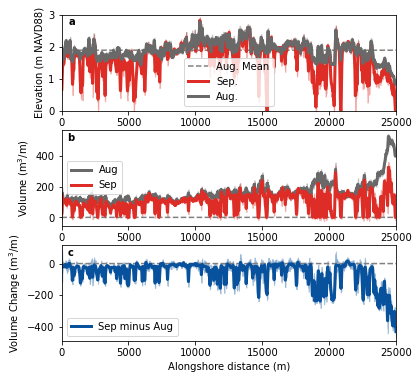

In [41]:
# NOTE - The volumes and widths are associated with the LAST MAP calculated in the loop above
# island width is wrong in places with no island volume
# TODO: maybe fix this in profile calcs?

width_platform0=platform_width.copy()
#width_platform0[plat_=10.]=0.
y = np.arange(0,nalong)

# average volume
vpmean = np.zeros_like(plat_vol)
vpstd = vpmean.copy()
vbmean = vpmean.copy()
vbstd = vpmean.copy()
apmean = vpmean.copy()
apstd = vpmean.copy()
elmean = vpmean.copy()
elstd = vpmean.copy()

nsmooth = 51
# smooth volumes and widths
for i in range(0,4):
    eltot = all_vol/island_width
    elmean[:,i] = running_nanmean(eltot[:,i],nsmooth)
    elstd[:,i] = running_stddev(eltot[:,i],nsmooth)
    vpmean[:,i] = running_nanmean(plat_vol[:,i],nsmooth)
    vpstd[:,i] = running_stddev(plat_vol[:,i],nsmooth)
    vpmean[:,i] = running_nanmean(beach_vol[:,i],nsmooth)
    vpstd[:,i] = running_stddev(beach_vol[:,i],nsmooth)
    apmean[:,i] = running_nanmean(width_platform0[:,i],nsmooth)
    apstd[:,i] = running_stddev(width_platform0[:,i],nsmooth)

# smooth max elevations in August
x = zdune[:,0]
xs = running_nanmean(x,501)
xstd = running_stddev(x,501)
print(np.shape(x),np.shape(xs))

#vp_err = np.sqrt( vpstd**2 + (width_platform*np.tile(sigma_tot,[nalong,1]).T)**2 ) 
mean_eltot = np.nanmean(eltot,0)

plt.figure(figsize=(6,6))
ax1=plt.subplot(311)
plt.plot(y,np.ones_like(y)*mean_eltot[0],'--',c='gray',label='Aug. Mean')

plt.plot(y,elmean[:,1],'-',linewidth=3,c=red3[2],label='Sep.')
ax1.fill_between(y,elmean[:,1]-elstd[:,1],elmean[:,1]+elstd[:,1],color=red3[2], alpha=0.3)

plt.plot(y,elmean[:,0],'-',linewidth=3,c='dimgray',label='Aug.')
ax1.fill_between(y,elmean[:,0]-elstd[:,0],elmean[:,0]+elstd[:,0],color='dimgray', alpha=0.3)


plt.ylim((0,3))
plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
plt.legend(loc='lower center')
plt.ylabel('Elevation (m NAVD88)')
plt.xlim((0,25000))

ax2=plt.subplot(312)
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')

ax2.fill_between(y,vpmean[:,0]-vpstd[:,0],vpmean[:,0]+vpstd[:,0],color='dimgray',alpha=0.3)
ax2.fill_between(y,vpmean[:,1]-vpstd[:,1],vpmean[:,1]+vpstd[:,1],color=red3[2], alpha=0.3)
plt.plot(y,vpmean[:,0],linewidth=3,c='dimgray',label='Aug')
plt.plot(y,vpmean[:,1],linewidth=3,c=red3[2],label='Sep')

plt.text(0.02, 0.92,'b ',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold')
#plt.ylim((-2,8))
plt.ylabel('Volume (m$^3$/m)')
plt.legend(loc='center left')
plt.xlim((0,25000))
#plt.xlabel('Alongshore distance (m)')

vol_change_1 = vpmean[:,1]-vpmean[:,0]
vol_change_std_1 = np.sqrt(vpstd[:,0]**2 + vpstd[:,1]**2)

ax3=plt.subplot(313)
plt.plot(y,np.zeros_like(y), '--',c='gray')
ax3.fill_between(y,vol_change_1-vol_change_std_1, vol_change_1+vol_change_std_1, color=nblue5[4],alpha=0.3)
plt.plot(y, vol_change_1, linewidth=3, c=nblue5[4], label='Sep minus Aug')
plt.text(0.02, 0.92,'c ',horizontalalignment='left',verticalalignment='center',transform = ax3.transAxes, fontweight='bold')
#plt.ylim((-2,8))
plt.ylabel('Volume Change (m$^3$/m)')
plt.legend(loc='lower left')
plt.xlim((0,25000))
plt.xlabel('Alongshore distance (m)')

fig_name = fig_dir+'island_elev_vol_vol_change.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = fig_dir+'island_elev_vol_vol_change.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

### Stats and plots for volume change


Stats for volume change:
  n, nnan, nvalid:  25000 0 25000
  mean, std, min, max   : -116.639 146.524 -744.009 76.484
  d5, d25, d50, d75, d95: -440.797 -186.381 -47.773 -14.667 12.129

Stats for volume change uncertainty:
  n, nnan, nvalid:  25000 0 25000
  mean, std, min, max   : 74.047 74.196 0.159 401.796
  d5, d25, d50, d75, d95: 9.228 22.380 42.736 102.175 236.162

Stats for smoothed volume change:
  n, nnan, nvalid:  25000 50 24950
  mean, std, min, max   : -116.287 139.633 -597.964 60.207
  d5, d25, d50, d75, d95: -417.230 -191.344 -51.713 -16.377 9.658


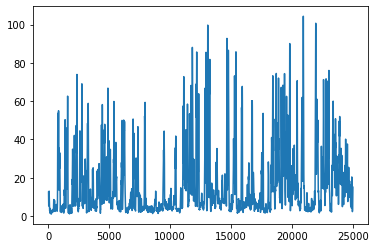

In [42]:
# volume change plots
# average volume
dvpmean = np.diff(plat_vol,axis=1)
dvmean = np.diff(all_vol,axis=1)
dvstd = np.nanstd(dvmean,axis=1)
dverr = np.sqrt(dvstd**2+0.08**2+0.08**2)

dvmeans = running_nanmean(dvmean[:,0],nsmooth)
dverrs = running_stddev(dverr,51)

print("\nStats for volume change:")
s = stat_summary( dvmean[:,0], iprint=True)
print("\nStats for volume change uncertainty:")
s = stat_summary( dverr, iprint=True)
print("\nStats for smoothed volume change:")
s = stat_summary( dvmeans, iprint=True)

plt.plot(dverrs)


   ### Plots of volume change v. island elevation - `volume_change_v_elev`

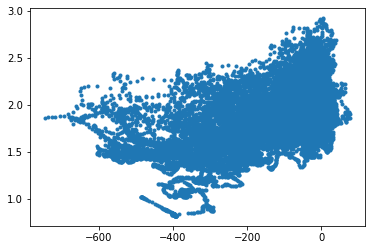

In [43]:
pelev = plat_vol / platform_width
aelev = all_vol / island_width
# dvmean
pelev.shape
dvmean.shape
np.sum(np.isnan(dvmean[:,0]))
plt.plot(dvmean[:,0],aelev[:,0],'.')

nbins= 6
n=24996; slope, intercept= 196.5382,-486.6894; r=0.4536 p=0.0000, stderr=2.4428 


<Figure size 432x288 with 0 Axes>

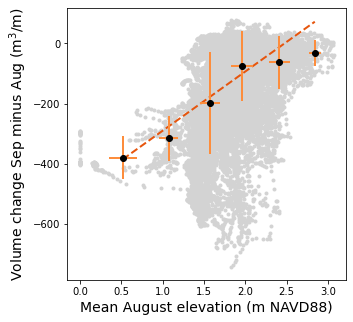

In [44]:
%run -i CoreBx_funcs
bin_edges = [.25, .75, 1.25, 1.75, 2.25, 2.75, 3.0]
nbins = len(bin_edges)-1
print('nbins=',nbins)
pm = np.ones(nbins)*np.nan
pstd = pm.copy()
dvm = pm.copy()
dvstd = pm.copy()
for i in range(nbins):
    pe = pelev[:,0]
    dvx = dvmean[:,0]
    pm[i]=np.nanmean( pe[(pe >= bin_edges[i]) & (pe < bin_edges[i+1])])
    pstd[i]=np.nanstd(pe[(pe >= bin_edges[i]) & (pe < bin_edges[i+1])])
    dvm[i]=  np.nanmean(dvx[(pe>= bin_edges[i]) & (pe < bin_edges[i+1])])
    dvstd[i]=np.nanstd( dvx[(pe>= bin_edges[i]) & (pe < bin_edges[i+1])])

n, slope, intercept, r2, p, stderr = nanlsfit( np.squeeze(pelev[:,0]), np.squeeze(dvmean[:,0]) )
    
plt.figure(figsize=(5,5))  
plt.plot(pelev[:,0],dvmean[:,0],'.',color='lightgray',zorder=1)
plt.plot(pm,intercept+pm*slope,'--',color=cols[3],linewidth=2,zorder=2)
plt.errorbar(pm, dvm, xerr=pstd, yerr=dvstd, fmt='ok', ecolor=cols[2], elinewidth=2,zorder=3)
plt.xlabel('Mean August elevation (m NAVD88)',fontsize=14)
plt.ylabel('Volume change Sep minus Aug (m$^3$/m)',fontsize=14)
fig_name = fig_dir+'volume_change_v_mean_elev.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = fig_dir+'volume_change_v_mean_elev.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

In [45]:
# get rid of nans
dvmean_augsep = dvpmean[np.isfinite(dvpmean[:,0]),0]
elev_aug = np.squeeze( pelev[np.isfinite(dvpmean[:,0]),0] )

df_transition=pd.DataFrame({'Pre-Dorian Elevation (m)': elev_aug, 'Volume Change (m$^3$/m)': dvmean_augsep})
df_transition

,Pre-Dorian Elevation (m),Volume Change (m$^3$/m)
0,1.35,-123.76
1,1.35,-122.01
2,1.35,-121.71
3,1.35,-120.33
4,1.34,-117.21
...,...,...
24995,1.47,-2.85
24996,1.47,-2.87
24997,1.47,-2.86
24998,1.46,-1.42


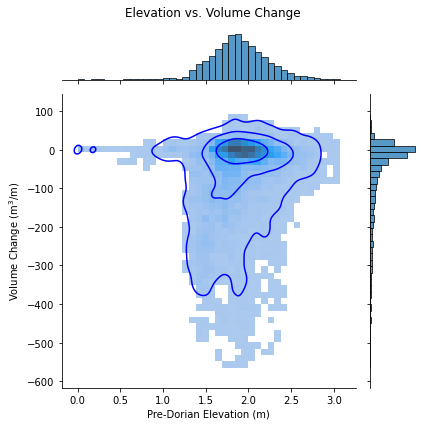

In [46]:

p1=sns.jointplot(data=df_transition, x='Pre-Dorian Elevation (m)', y='Volume Change (m$^3$/m)', bins=40, kind="hist", marginal_kws=dict(bins=40))
p1.fig.suptitle("Elevation vs. Volume Change")
p1.plot_joint(sns.kdeplot, color="b", zorder=1, levels=4)
p1.fig.tight_layout()
plt.savefig(fig_dir+'elev_volume_histogram.svg')

### Clip out the Long Point Cabins from the dune crest profiles - `zdune_clip`

In [47]:
# Compare August dune crest elevation with volume change
# kludge to remove cabins in zdune
zdune_clip = zdune.copy()
clip0 = np.argwhere(zdune[2000:4000,0]>4)
clip1 = np.argwhere(zdune[2000:4000,0]>4)
zdune_clip[2000+clip0,0]=3
zdune_clip[2000+clip1,1]=3


all_good = np.isfinite(dvpmean[:,0]+zdune_clip[:,0]+zdune_clip[:,1])

df_zdune_transition=pd.DataFrame({'Pre-Dorian Dune Crest Elevation (m)': zdune[all_good,0], 'Volume Change (m$^3$/m)': dvpmean[all_good,0]})
df_zdune_transition

,Pre-Dorian Dune Crest Elevation (m),Volume Change (m$^3$/m)
0,2.00,-107.17
1,2.00,-106.22
2,2.00,-107.42
3,2.00,-109.40
4,2.01,-114.64
...,...,...
23220,0.45,0.00
23221,0.38,0.00
23222,0.33,0.00
23223,0.33,0.00


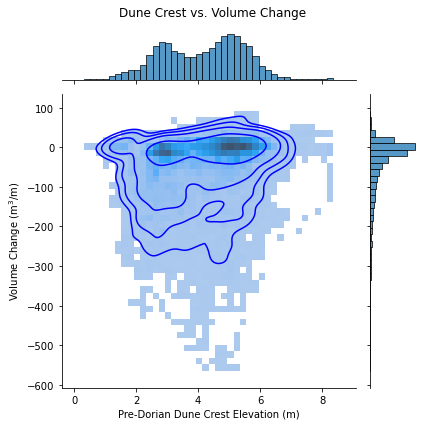

In [77]:
p1=sns.jointplot(data=df_zdune_transition, x='Pre-Dorian Dune Crest Elevation (m)', y='Volume Change (m$^3$/m)', bins=40, kind="hist", marginal_kws=dict(bins=40))
p1.fig.suptitle("Dune Crest vs. Volume Change")
#p1.plot_joint(sns.kdeplot, color="b", zorder=1, levels=[.05,.1,.2,.5])
p1.plot_joint(sns.kdeplot, color='b', zorder=1, levels=[.05,.1,.2,.5])
p1.fig.tight_layout()
plt.savefig(fig_dir+'dune_crest_volume_change_histogram.svg')

### The wrack values changed with the EBK 2022 map

In [49]:
# Wrack positions extracted from Jin-Si's EBK 2022 map.
df=pd.read_csv(drv+'crs/proj/2019_DorianOBX/WayneWright_flights/CoreBx/Wrack_positions_NCB_2019-09_EBK_2022.csv',header = 0)
wrack_z = df['EBK_2022'].values
df.describe()

,Id,X,Y,EBK_2020,EBK_2022
count,10097.0,10097.00,1.01e+04,10097.00,10097.00
mean,6436.0,391073.14,3.87e+06,2.51,2.32
std,2914.9,3816.14,3.60e+03,0.22,0.23
min,1388.0,384025.60,3.86e+06,1.43,1.18
25%,3912.0,388217.19,3.87e+06,2.36,2.16
50%,6436.0,390236.95,3.87e+06,2.53,2.35
75%,8960.0,394415.27,3.87e+06,2.67,2.50
max,11484.0,400519.83,3.88e+06,3.32,3.00


In [50]:
# rotate to island coordinates
wrack_x, wrack_y = UTM2Island( df['X'].values, df['Y'].values, eoff=r['e0'], noff=r['n0'], rot=r['theta'] )

# sort by alongshore location
isort = np.argsort(wrack_x)
wrack_x = wrack_x[isort]
wrack_y = wrack_y[isort]
wrack_z = wrack_z[isort]

# smooth
wrackx_mean = running_nanmean(wrack_x, nsmooth)
wrackz_mean = running_nanmean(wrack_z, nsmooth)
wrackz_std = running_stddev(wrack_z, nsmooth)
stat_summary(wrackz_mean)

{'n': 10097,
 'nnan': 50,
 'nvalid': 10047,
 'mean': 2.3244831465250577,
 'std': 0.16582609049656774,
 'min': 1.8045582352941176,
 'max': 2.686892941176471,
 'd5': 2.0273645490196075,
 'd25': 2.2232078431372546,
 'd50': 2.338616470588235,
 'd75': 2.4487973529411766,
 'd95': 2.5794966470588236}

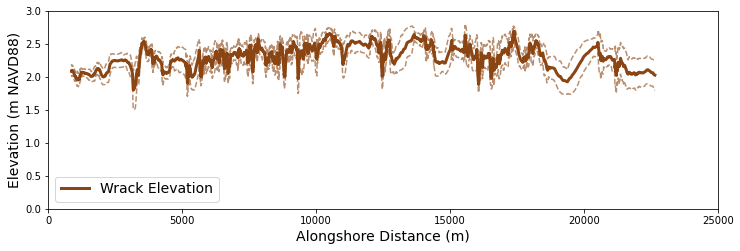

In [51]:
plt.figure(figsize=(12,8))
ax1=plt.subplot(211)
plt.plot(wrackx_mean, wrackz_mean + wrackz_std,'--',c='saddlebrown',alpha=.6)
plt.plot(wrackx_mean, wrackz_mean - wrackz_std,'--',c='saddlebrown',alpha=.6)
plt.plot(wrackx_mean, wrackz_mean,linewidth=3,c='saddlebrown',label="Wrack Elevation")

plt.ylim((0, 3))
#plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
plt.legend(fontsize=14)
plt.ylabel('Elevation (m NAVD88)',fontsize=14)
plt.xlim((0,25000))
plt.xlabel('Alongshore Distance (m)',fontsize=14)
fig_name = 'wrack_elev_island.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = 'wrack_elev_island.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

### Island-wide dune crest elevations - `dune_crest_diff`

`zcrest0` is the elevation of the dune crest in August, and the elevations of the same location in subsequent years

* Smooth the curves
* plot dune crest elevations for Aug, Sep, and Nov
* plot dune crest changes


In [52]:
print('August Dune Crest Stats')
_ = stat_summary(zdune[:,0],iprint=True)
print()
print('September Dune Crest Stats')
_ = stat_summary(zdune[:,1],iprint=True)
print()
print('September Wrack Stats')
_ = stat_summary(wrack_z,iprint=True)

August Dune Crest Stats
  n, nnan, nvalid:  25000 19 24981
  mean, std, min, max   : 4.031 1.339 0.171 8.361
  d5, d25, d50, d75, d95: 1.895 2.903 4.155 5.121 5.964

September Dune Crest Stats
  n, nnan, nvalid:  25000 1776 23224
  mean, std, min, max   : 3.776 1.658 -0.387 8.404
  d5, d25, d50, d75, d95: 0.683 2.691 4.123 5.089 5.917

September Wrack Stats
  n, nnan, nvalid:  10097 0 10097
  mean, std, min, max   : 2.323 0.235 1.177 3.002
  d5, d25, d50, d75, d95: 1.912 2.161 2.352 2.498 2.668


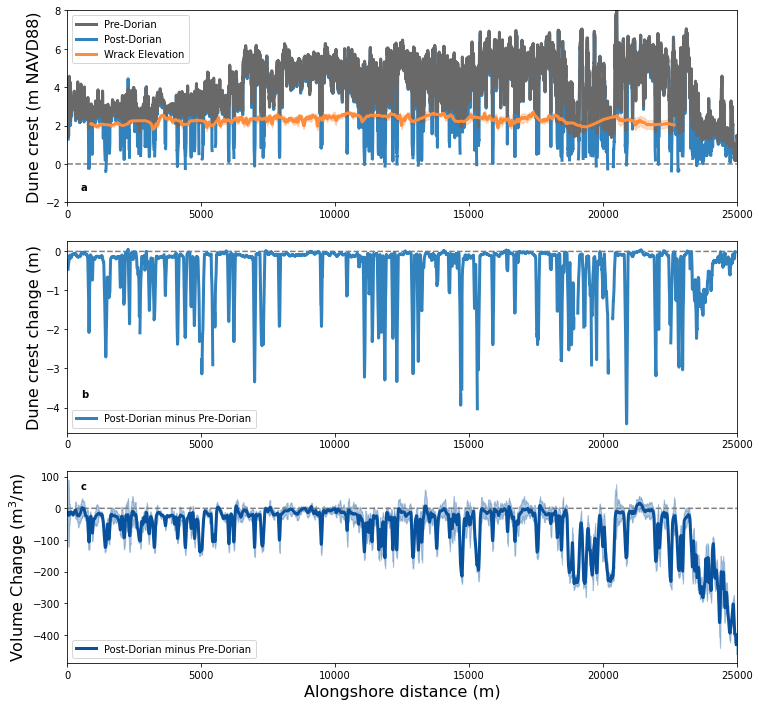

In [53]:
plt.figure(figsize=(12,12))
ax1=plt.subplot(311)
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')
#plt.plot(y,zdune[:,1],'-',linewidth=3,c=nblue5[3],label='Sep')
#plt.plot(y,zdune[:,0],'-',linewidth=3,c='dimgray',label='Aug')
plt.plot(y,zdune_clip[:,1],'-',linewidth=3,c=nblue5[3],label='Post-Dorian')
plt.plot(y,zdune_clip[:,0],'-',linewidth=3,c='dimgray',label='Pre-Dorian')


#wrack_col = 'saddlebrown'
wrack_col = cols[2]
ax1.fill_between(wrackx_mean, wrackz_mean + wrackz_std, wrackz_mean - wrackz_std, color=wrack_col,alpha=0.3)
#ax1.fill_between(wrackx_mean, wrackz_mean - wrackz_std, color=wrack_col,alpha=0.3)
#plt.plot(wrackx_mean, wrackz_mean + wrackz_std,'--',c=wrack_col,alpha=.6)
#plt.plot(wrackx_mean, wrackz_mean - wrackz_std,'--',c=wrack_col,alpha=.6)
plt.plot(wrackx_mean, wrackz_mean,linewidth=3,c=wrack_col,label="Wrack Elevation")

plt.text(0.02, 0.08,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
plt.ylabel('Dune crest (m NAVD88)',fontsize=16)

handles, labels = plt.gca().get_legend_handles_labels()
order = [1,0,2]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc='upper left')

#plt.legend()
plt.ylim((-2.,8.))
plt.xlim((0,25000))

xds0 = running_nanmean( zdune[:,1]-zdune[:,0], 51)
xdstd0 = running_stddev( zdune[:,1]-zdune[:,0], 51)

ax2=plt.subplot(312)
plt.plot(y,np.ones_like(y)*0.,'--',c='gray')

plt.plot(y,xds0,'-',linewidth=3,c=nblue5[3],label='Post-Dorian minus Pre-Dorian')
#plt.plot(y,xds1,'-',linewidth=3,c=blue5[3],label=pnames[2]+' minus '+pnames[0])
#plt.plot(y,xds2,'-',linewidth=3,c=blue5[4],label=pnames[3]+' minus '+pnames[0])
plt.legend()
plt.text(0.02, 0.2,'b',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold')
plt.ylabel('Dune crest change (m)',fontsize=16)
plt.xlim((0,25000))

ax3=plt.subplot(313)
plt.plot(y,np.zeros_like(y), '--',c='gray')
ax3.fill_between(y,vol_change_1-vol_change_std_1, vol_change_1+vol_change_std_1, color=nblue5[4],alpha=0.3)
plt.plot(y, vol_change_1, linewidth=3, c=nblue5[4], label='Post-Dorian minus Pre-Dorian')
plt.text(0.02, 0.92,'c ',horizontalalignment='left',verticalalignment='center',transform = ax3.transAxes, fontweight='bold')
#plt.ylim((-2,8))
plt.ylabel('Volume Change (m$^3$/m)',fontsize=16)
plt.legend(loc='lower left')
plt.xlim((0,25000))
plt.xlabel('Alongshore distance (m)',fontsize=16)

fig_name = fig_dir+'dune_crest_diff.svg'
plt.savefig(fig_name,bbox_inches='tight', format='svg')
fig_name = fig_dir+'dune_crest_diff.png'
plt.savefig(fig_name,bbox_inches='tight', format='png', dpi = 200)

In [54]:
print('Volume Change')
_ = stat_summary(wrack_z,iprint=True)

Volume Change
  n, nnan, nvalid:  10097 0 10097
  mean, std, min, max   : 2.323 0.235 1.177 3.002
  d5, d25, d50, d75, d95: 1.912 2.161 2.352 2.498 2.668


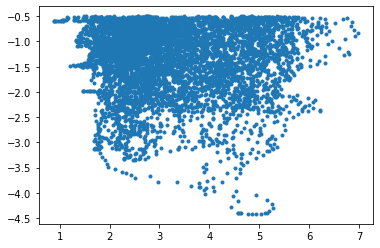

In [55]:
# No clear relationship between intial dune crest and change
plt.plot(zdune_clip[xds0<-.5,0],xds0[xds0<-.5],'.')

[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75 2.   2.25 2.5  2.75 3.   3.25
 3.5  3.75 4.   4.25 4.5  4.75 5.   5.25 5.5  5.75 6.   6.25 6.5  6.75
 7.   7.25 7.5  7.75 8.  ]


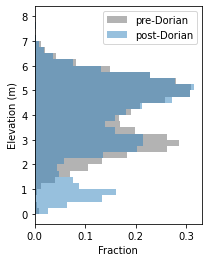

In [56]:
bind = np.arange(0.,8.25,.25)
print(bind)
#histtype = 'step'
histtype = 'bar'
plt.figure( figsize=(3,4))
h  = plt.hist(zdune_clip[:,0],bins = bind, orientation='horizontal', density=True, alpha=.5, label='pre-Dorian',
              histtype=histtype,linewidth=4, color='dimgray')
h  = plt.hist(zdune_clip[:,1],bins = bind, orientation='horizontal', density=True, alpha=.5, label='post-Dorian',
              histtype=histtype,linewidth=4, color = nblue5[3] )
plt.ylabel('Elevation (m)')
plt.xlabel('Fraction')
plt.legend()

In [57]:
df_zcrest=pd.DataFrame({'Pre-Dorian Dune Crest Elevation (m)': zdune_clip[all_good,0],
                        'Post-Dorian Dune Crest Elevation (m)': zdune_clip[all_good,1]})
df_zcrest

,Pre-Dorian Dune Crest Elevation (m),Post-Dorian Dune Crest Elevation (m)
0,2.00,1.30
1,2.00,1.36
2,2.00,1.40
3,2.00,1.43
4,2.01,1.43
...,...,...
23220,0.45,0.32
23221,0.38,0.32
23222,0.33,0.35
23223,0.33,0.32


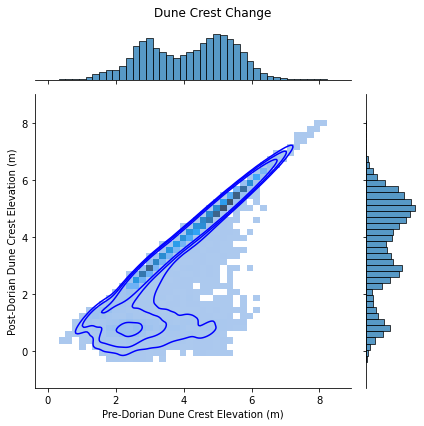

In [79]:
p1=sns.jointplot(data=df_zcrest, x='Pre-Dorian Dune Crest Elevation (m)', y='Post-Dorian Dune Crest Elevation (m)', bins=40, kind="hist", marginal_kws=dict(bins=40))
p1.fig.suptitle("Dune Crest Change")
p1.plot_joint(sns.kdeplot, color="b", zorder=1, levels=[.05,.1,.2])
p1.fig.tight_layout()
plt.savefig(fig_dir+'dune_crest_change_histogram.svg')

(array([  28.,   49.,   82.,  145.,  252.,  452.,  592.,  655.,  392.,
         312.,  293.,  196.,  177.,  183.,  174.,  386.,  587.,  772.,
         874.,  990.,  722.,  739.,  562.,  554.,  532.,  682.,  683.,
         795.,  898., 1096., 1157., 1267., 1248., 1151.,  992.,  876.,
         596.,  379.,  278.,  173.,   99.,   63.,   47.,    7.,   10.,
           5.,    7.,    8.,    2.,    6.]),
 array([-0.38670757, -0.21664671, -0.04658584,  0.12347503,  0.2935359 ,
         0.46359677,  0.63365764,  0.80371851,  0.97377938,  1.14384025,
         1.31390111,  1.48396198,  1.65402285,  1.82408372,  1.99414459,
         2.16420546,  2.33426633,  2.5043272 ,  2.67438807,  2.84444893,
         3.0145098 ,  3.18457067,  3.35463154,  3.52469241,  3.69475328,
         3.86481415,  4.03487502,  4.20493589,  4.37499675,  4.54505762,
         4.71511849,  4.88517936,  5.05524023,  5.2253011 ,  5.39536197,
         5.56542284,  5.7354837 ,  5.90554457,  6.07560544,  6.24566631,
         6.41572

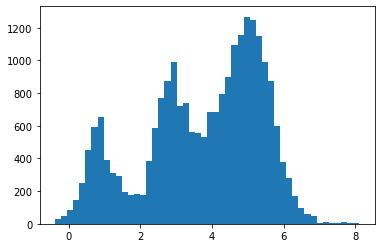

In [59]:
plt.hist(zdune_clip[:,1],bins = 50)

wrack elevations
  n, nnan, nvalid:  10097 0 10097
  mean, std, min, max   : 2.323 0.235 1.177 3.002
  d5, d25, d50, d75, d95: 1.912 2.161 2.352 2.498 2.668
zcrest:
  n, nnan, nvalid:  4 3 1
  mean, std, min, max   : -0.006 0.000 -0.006 -0.006
  d5, d25, d50, d75, d95: -0.006 -0.006 -0.006 -0.006 -0.006


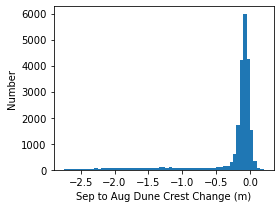

<Figure size 432x288 with 0 Axes>

In [60]:
print('wrack elevations')
stat_summary(wrack_z,iprint=True)
print('zcrest:')
stat_summary(zdune[1,:]-zdune[0,:],iprint=True)
num_bins = 10
bins = np.arange(-2.75,.25,.05)
#print(bins)
fig, ax = plt.subplots(figsize=(4,3))

#histogram of the data
n, bins, patches = ax.hist(zdune[:,1]-zdune[:,0], bins)

ax.set_xlabel('Sep to Aug Dune Crest Change (m)')
ax.set_ylabel('Number')
#ax.set_title(r'Dune Crest Change')
fig.tight_layout()
plt.show()
plt.savefig('crest_change_histogram.png',bbox_inches='tight', format='png', dpi = 200,c=blue5[2])

### Compare crest heights with volume change - `dune_crest_v_volume_change`

In [61]:
crest_aug = np.squeeze( zdune[np.isfinite(dvmean[:,0]),0] )

df_crest_vol=pd.DataFrame({'August Dune Crest Elevation (m)': elev_aug, 'Volume Change (m$^3$/m)': dvmean_augsep})
df_crest_vol

,August Dune Crest Elevation (m),Volume Change (m$^3$/m)
0,1.35,-123.76
1,1.35,-122.01
2,1.35,-121.71
3,1.35,-120.33
4,1.34,-117.21
...,...,...
24995,1.47,-2.85
24996,1.47,-2.87
24997,1.47,-2.86
24998,1.46,-1.42


25000


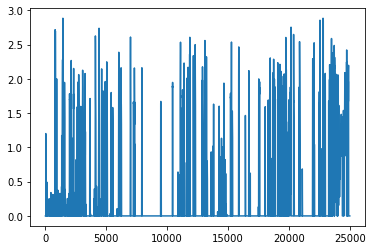

In [62]:
# estimate channel depths
# why did I do this?

cthresh=2.5
chSep = zdune[:,1].copy()
chSep[chSep>=cthresh]=cthresh
chSep = chSep-cthresh
chSep[ ~np.isfinite(chSep)] = 0.
plt.plot(y,-chSep)
print(np.sum(np.isfinite(chSep)))
#plt.plot(y[ss:se],zmax_s0[ss:se])

In [63]:
%run -i CoreBx_funcs
ch_diff = np.squeeze( zdune_clip[:,1]-zdune_clip[:,0] )
npts = 5 # number of points to smooth over
vthresh=.5 # threshold for minimum channel depth
hthresh=15. # minimum channel width
nc, channel_ctr, channel_area, channel_width, channel_max_depth, channel_avg_depth = analyze_channels(
    y, -ch_diff, npts=npts, vthresh=vthresh, hthresh=hthresh)

print('September:')
print('Channel depths:')
cz0 = stat_summary(channel_avg_depth,iprint=True)
print('Channel widths:')
cw0 = stat_summary(channel_width,iprint=True)
print('Channel areas:')
ca0 = stat_summary(channel_area,iprint=True)

Total channel area m^2/m: 0.27
September:
Channel depths:
  n, nnan, nvalid:  97 0 97
  mean, std, min, max   : 1.981 0.687 0.716 3.959
  d5, d25, d50, d75, d95: 1.059 1.408 1.992 2.401 3.244
Channel widths:
  n, nnan, nvalid:  97 0 97
  mean, std, min, max   : 31.423 15.094 16.000 102.000
  d5, d25, d50, d75, d95: 16.800 21.000 27.000 37.000 58.400
Channel areas:
  n, nnan, nvalid:  97 0 97
  mean, std, min, max   : 62.166 34.580 14.928 180.000
  d5, d25, d50, d75, d95: 20.072 38.602 53.971 77.961 126.694


<Figure size 432x288 with 0 Axes>

In [64]:
# write to a .csv via Pandas
channel_metrics = pd.DataFrame({'Center':channel_ctr,'Area':channel_area,'Width':channel_width,\
                                'Max depth':channel_max_depth,'Avg_depth':channel_avg_depth})
channel_metrics.to_csv(out_dir+'channel_metrics.csv',index=False,float_format='%.4f')
# stats for those wider than 5 m
pd.set_option("display.precision", 1)
channel_metrics.loc[channel_metrics['Width']>=5.].describe()

,Center,Area,Width,Max depth,Avg_depth
count,97.0,97.0,97.0,97.0,97.0
mean,13325.4,62.2,31.4,2.8,2.0
std,7475.9,34.8,15.2,1.0,0.7
min,790.5,14.9,16.0,0.9,0.7
25%,6203.5,38.6,21.0,2.0,1.4
50%,13114.0,54.0,27.0,2.9,2.0
75%,19994.0,78.0,37.0,3.4,2.4
max,24727.0,180.0,102.0,5.2,4.0


Number of channels with area >=5: (1, 97)


Text(0.02, 0.92, 'b')

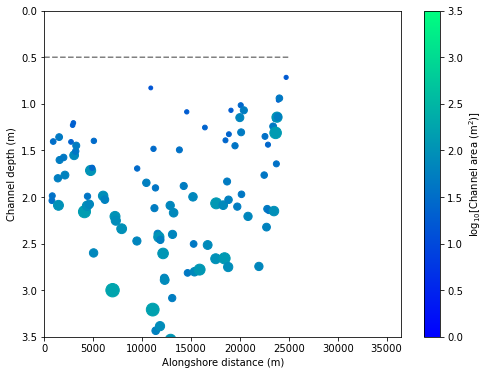

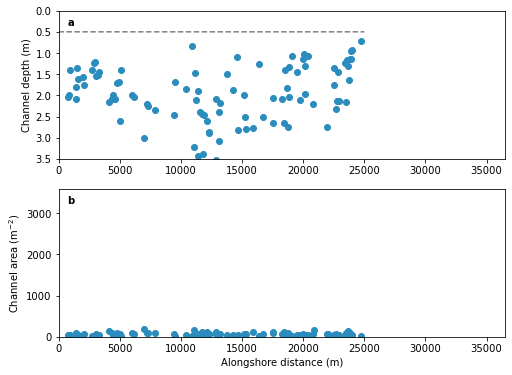

In [65]:
ia = np.where(channel_area>=5.)
print('Number of channels with area >=5:',np.shape(ia))
s = np.array(channel_area[ia])
col = np.array(channel_avg_depth[ia])

plt.figure(figsize=(8,6))
ax1=plt.subplot(111)
plt.plot(y,np.ones_like(y)*vthresh,'--',c='gray')
plt.scatter(channel_ctr[ia],channel_avg_depth[ia],s,np.log10(s),cmap=plt.cm.winter)
plt.ylim((3.5,0))
plt.ylabel('Channel depth (m)')
plt.xlim((0,36500))
#plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')
plt.clim((0,3.5))
cbar=plt.colorbar()
cbar.ax.set_ylabel('log$_{10}$[Channel area (m$^2$)]')
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)')
plt.savefig('channel_depth_bubbles.png',bbox_inches='tight', format='png', dpi = 200)

plt.figure(figsize=(8,6))
ax1=plt.subplot(211)
plt.plot(y,np.ones_like(y)*vthresh,'--',c='gray')
plt.plot(channel_ctr[ia],channel_avg_depth[ia],'.',markersize=12,color=blue5[3])
plt.ylim((3.5,0))
plt.ylabel('Channel depth (m)')
plt.xlim((0,36500))
plt.text(0.02, 0.92,'a',horizontalalignment='left',verticalalignment='center',transform = ax1.transAxes, fontweight='bold')

ax2=plt.subplot(212)
plt.plot(channel_ctr[ia],channel_area[ia],'.',markersize=12,color=blue5[3])
plt.ylim((0,3600))
plt.ylabel('Channel area (m$^{-2}$)')
plt.xlim((0,36500))
plt.xlabel('Alongshore distance (m)')
plt.text(0.02, 0.92,'b',horizontalalignment='left',verticalalignment='center',transform = ax2.transAxes, fontweight='bold')


# remove one weird point - this might be the channel that connects to the back
ibad = np.argwhere(channel_avg_depth>=3)
print('Removing data point at: ',ibad)
print('...where channel_avg_depth = ',channel_avg_depth[ibad])
channel_avg_depth[ibad]=channel_avg_depth[ia].mean()
channel_area[ibad]=channel_area[ia].mean()
channel_width[ibad]=channel_area[ibad]/channel_avg_depth[ibad]

Bin edges:  [    0.  1000.  2000.  3000.  4000.  5000.  6000.  7000.  8000.  9000.
 10000. 11000. 12000. 13000. 14000. 15000. 16000. 17000. 18000. 19000.
 20000. 21000. 22000. 23000. 24000. 25000. 26000. 27000. 28000. 29000.
 30000. 31000. 32000. 33000. 34000. 35000. 36000.]
  n, nnan, nvalid:  97 0 97
  mean, std, min, max   : 1.709 0.526 0.676 3.305
  d5, d25, d50, d75, d95: 0.948 1.257 1.671 2.027 2.598


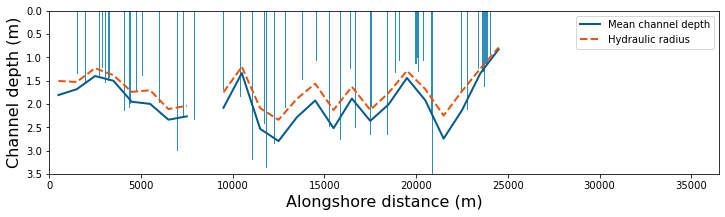

In [66]:
binw = 1000.
bins = np.arange(0.,36001.,binw)
print('Bin edges: ',bins)

bin_ctr = bins[0:-1]+0.5*binw
ychan = channel_ctr[ia]
data = channel_avg_depth[ia]
digitized = np.digitize(ychan, bins)
bin_mean = [data[digitized == i].mean() for i in range(1, len(bins))]
bin_std = [data[digitized == i].std() for i in range(1, len(bins))]

# hydraulic radius
Rh = channel_area/(2.*channel_avg_depth+channel_width)
stat_summary(Rh[ia],iprint=True)
data= Rh[ia]
Rh_mean = [data[digitized == i].mean() for i in range(1, len(bins))]
Rh_std = [data[digitized == i].std() for i in range(1, len(bins))]

plt.figure(figsize=(12,3))

plt.bar(channel_ctr[ia],channel_avg_depth[ia],width=channel_width[ia],color=blue5[3])
plt.plot(bin_ctr,bin_mean,'-',color=blue5[4],linewidth=2,label='Mean channel depth')
plt.plot(bin_ctr,Rh_mean,'--',color=cols[3],linewidth=2,label='Hydraulic radius')
plt.ylim((3.5,0))
plt.xlabel('Alongshore distance (m)',fontsize=16)
plt.ylabel('Channel depth (m)',fontsize=16)
plt.legend()
plt.xlim((0,36500))
plt.savefig('channel_depth_bars.png',bbox_inches='tight', format='png', dpi = 200)

Channel area (m2):
  n, nnan, nvalid:  97 0 97
  mean, std, min, max   : 62.166 34.580 14.928 180.000
  d5, d25, d50, d75, d95: 20.072 38.602 53.971 77.961 126.694


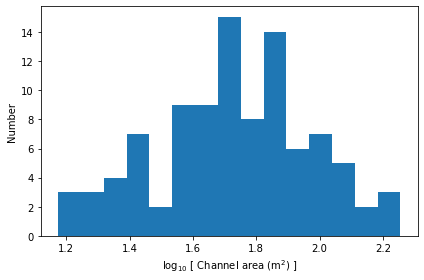

<Figure size 432x288 with 0 Axes>

In [67]:
print('Channel area (m2):')
stat_summary(channel_area[ia],iprint=True)
num_bins = 15
#bins = np.arange(-2.75,.25,.25)
#print(bins)
fig, ax = plt.subplots()

n, bins, patches = ax.hist(np.log10(channel_area[ia]), num_bins)

ax.set_xlabel('log$_{10}$ [ Channel area (m$^{2}$) ]')
ax.set_ylabel('Number')
#ax.set_title(r'Dune Crest Change')
fig.tight_layout()
plt.show()
plt.savefig('channel_area_histogram.png',bbox_inches='tight', format='png', dpi = 200)

### Estimate flow velocity and total discharge

https://en.wikipedia.org/wiki/Manning_formula

http://www.fsl.orst.edu/geowater/FX3/help/8_Hydraulic_Reference/Mannings_n_Tables.htm

In [68]:
### Estimate flow velocity using open-channel flow formula
ychan = channel_ctr[ia]
depth=channel_avg_depth[ia]

mann=.025
mann_rough = 0.03
mann_smooth = 0.02
Slope = 1./300.
konv=1.
rhow = 1027.
rhos = 2650.
d50 = 0.43e-3 # Ruggerio, S. Core Banks
d90 = 1.e-3
# print("Base case")

# d50 = 0.25e-3 # Ruggerio, S. Core Banks
# d90 = 0.34e-3
# print("Fine Sediment case")

# Slope = 1./400.
# print("Low slope case")

# Slope = 1./200.
# print("High slope case")

#mann = 0.02
# print("Smooth n case")

# mann = 0.03
# print("Rough n case")

print("Mannings n {:.3f}, slope {:.4f}, d50 (mm) {:.3f}, d90 (mm) {}".\
     format(mann, Slope, d50*1000, d90*1000))
s = rhos/rhow
nu = 1.36e-6
print('s: ',s)
g = 9.81
Dstar = (g*(s-1)/nu**2)**(1./3.)*d50 # Soulsby eqn 99
ws = (nu/d50)*(np.sqrt(10.36**2+1.049*Dstar**3)-10.36) # Soulsby eqn 102
wstar = ws/((g*(s-1)/nu**2)**(1./3.))
print('Dstar:',Dstar,'ws:',ws,'wstar: ',wstar)

theta_cr = (0.3/(1.+1.2*Dstar))+0.055*(1.-np.exp(-0.020*Dstar)) # Soulsby eqn 77
tauc = theta_cr*(g*rhow*(s-1)*d50)
print('Tauc =',tauc)

# fric = 0.04 # Fig. 3.3 in Dyer - not used
# Cdf = fric/8.
Cdn =   g*mann**2/(depth**(1./3.))

print("Cdn")
stat_summary(Cdn,iprint=True)
Vel   = (konv/mann)*Rh[ia]**(2./3.)*np.sqrt(Slope)
Vello = (konv/mann_rough)*Rh[ia]**(2./3.)*np.sqrt(Slope)
Velhi = (konv/mann_smooth)*Rh[ia]**(2./3.)*np.sqrt(Slope)

Froude = Vel/np.sqrt(g*depth)
tau0   = Cdn*rhow*Vel**2.


print("Froude from Manning")
stat_summary(Froude,iprint=True)
print("Velocity from Manning")
stat_summary(Vel,iprint=True)
print("Tau0 from Manning")
stat_summary(tau0,iprint=True)

### Estimate bed stress from bottom stress
# These give similar, but slightly higher numbers
# taub = rhow*g*depth*Slope[1]
# Ubar = np.sqrt(taub/(rhow*Cdn))
# print('Ubar from slope')
# stat_summary(Ubar,iprint=True)
# print('Taub from slope')
# stat_summary(taub,iprint=True)

# Van Rijn (Eqn 133)
Ucr = 0.19*d50**0.1*np.log10(4.*depth/d90)
if d50>0.5e-3:
    Ucr = 8.5*d50**0.6*np.log10(4.*depth/d90)
Ubar = Vel
curly = (Ubar-Ucr)/np.sqrt((s-1)*g*d50)
qbvr = 0.005*Ubar*depth*curly**2.4*(d50/depth)**1.2
qsvr = 0.012*Ubar*depth*curly**2.4*(d50/depth)*Dstar**(-.6)

Ubar = Vello
curly = (Ubar-Ucr)/np.sqrt((s-1)*g*d50)
qbvrlo = 0.005*Ubar*depth*curly**2.4*(d50/depth)**1.2
qsvrlo = 0.012*Ubar*depth*curly**2.4*(d50/depth)*Dstar**(-.6)

Ubar = Velhi
curly = (Ubar-Ucr)/np.sqrt((s-1)*g*d50)
qbvrhi = 0.005*Ubar*depth*curly**2.4*(d50/depth)**1.2
qsvrhi = 0.012*Ubar*depth*curly**2.4*(d50/depth)*Dstar**(-.6)

Mannings n 0.025, slope 0.0033, d50 (mm) 0.430, d90 (mm) 1.0
s:  2.5803310613437196
Dstar: 8.734704380597039 ws: 0.05704776349367495 wstar:  2.8083993725959964e-06
Tauc = 0.2392398582172001
Cdn
  n, nnan, nvalid:  97 0 97
  mean, std, min, max   : 0.005 0.001 0.004 0.007
  d5, d25, d50, d75, d95: 0.004 0.005 0.005 0.005 0.006
Froude from Manning
  n, nnan, nvalid:  97 0 97
  mean, std, min, max   : 0.748 0.035 0.671 0.831
  d5, d25, d50, d75, d95: 0.695 0.724 0.748 0.771 0.804
Velocity from Manning
  n, nnan, nvalid:  97 0 97
  mean, std, min, max   : 3.266 0.678 1.779 5.124
  d5, d25, d50, d75, d95: 2.229 2.689 3.253 3.699 4.364
Tau0 from Manning
  n, nnan, nvalid:  97 0 97
  mean, std, min, max   : 54.690 16.316 22.262 104.501
  d5, d25, d50, d75, d95: 30.805 41.043 53.482 65.293 80.011


### Write sed transport calcs to a .csv via Pandas

In [69]:
flow_calcs = pd.DataFrame({'Center [m]':ychan,'Area [m2]':channel_area[ia],'Width [m]':channel_width[ia],\
                                'Max depth [m]':channel_max_depth[ia],'Avg_depth [m]':channel_avg_depth[ia],\
                          'Velocity [m/s]':Vel,'Bedload [m2/s]':qbvr,'Sus load [m2/s]':qsvr,\
                           'Qwater [m3/s]':Vel*channel_area[ia],'SSC [kg/m3]':rhos*qsvr/q})
flow_calcs.to_csv(out_dir+'flow_calcs.csv',index=False,float_format='%.4f')

NameError: name 'q' is not defined